# Ocean Kita Station Analysis

## Defining Business Questions
- **Question 1:** Apakah ada perbedaan jumlah sampah di sungai saat terjadi angin kencang dibandingkan dengan saat angin tenang?

- **Question 2:** Bagaimana pengaruh pasang surut terhadap jumlah sampah di sungai? Apakah saat air pasang, jumlah sampah cenderung meningkat atau menurun?

- **Question 3:** Apakah ada pola penumpukan sampah di sungai tertentu yang dipengaruhi oleh pergerakan pasut?

- **Question 4:** Apakah ada korelasi antara intensitas curah hujan dan jumlah sampah di sungai? Apakah hujan lebat menyebabkan peningkatan volume sampah yang masuk ke sungai?

- **Question 5:** Bagaimana perubahan jumlah sampah di sungai setelah terjadi hujan lebat? Apakah ada hubungan antara curah hujan dan peningkatan sampah?

- **Question 6:** Apakah ada kombinasi dari faktor-faktor lingkungan (angin, pasut, curah hujan) yang secara signifikan mempengaruhi jumlah sampah? (Misalnya, angin kencang dan hujan lebat secara bersamaan)

- **Question 7:** Berdasarkan data dan pertanyaan diatas, tentukan karakteristik dan pengaruh perubahan jumlah sampah dimasing-masing sungai (Misal, Sungai Ciliwung lebih dipengaruhi oleh pasut, sementara angin dan curah hujan tidak terlalu)



## Setup Workspace

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
with open('Guide.txt', 'r') as f:
  guide_content = f.read()
print(guide_content)

1. tentukan stasiun cuaca terdekat
2. tentukan stasiun cuaca yang dilewati oleh sungai tersebut
3. masukan pengaruh curah hujan sebelumnya (apabila hulu sungai melewati stasiun bogor)
4. cari hubungannya

Cisadane: bogor, priok
TJ pasir: Tarik ke Tj priok
Cilampe: Tarik ke Priok
Dadap: Tarik ke Priok
Cengkareng: Priok, kemayoran, bogor
Grogol: Priok, kemayoran, bogor
Besar: Priok, Kemayoran
Ciliwung: Priok, kemayoran, bogor
Sunter: Priok
Blencong: priok
BKT: Priok
Cikeos: Priok Halim
Citarum: Priok Halim

Pertanyaan yang ingin dijawab
1. Apakah ada perbedaan jumlah sampah di sungai saat terjadi angin kencang dibandingkan dengan saat angin tenang?
2. Bagaimana pengaruh pasang surut terhadap jumlah sampah di sungai? Apakah saat air pasang, jumlah sampah cenderung meningkat atau menurun?
3. Apakah ada pola penumpukan sampah di sungai tertentu yang dipengaruhi oleh pergerakan pasut?
4. Apakah ada korelasi antara intensitas curah hujan dan jumlah sampah di sungai? Apakah hujan lebat menyeba

In [3]:
ds = pd.read_csv('dataset/Data.csv')
dl = pd.read_csv('dataset/dl.csv')

In [4]:
ds.info()
ds.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            56 non-null     int64  
 1   Name                          56 non-null     object 
 2   X                             56 non-null     float64
 3   Y                             56 non-null     float64
 4   Time                          56 non-null     object 
 5   Weather                       56 non-null     object 
 6   Tides                         56 non-null     object 
 7   MSL                           56 non-null     float64
 8   Tides in Number               56 non-null     float64
 9   Debri Quantity                56 non-null     int64  
 10  Debri Coverage (m^2)          56 non-null     float64
 11  Organic Quantity              56 non-null     int64  
 12  Plastic Quantity              56 non-null     int64  
 13  Organic

,id,Name,X,Y,Time,Weather,Tides,MSL,Tides in Number,Debri Quantity,...,Organic (%),Plastic (%),Compact Coverage (m^2),Scatter Coverage (m^2),Compact (%),Scatter (%),Approximate Moving Debri,Approximate Stuck Debri,Approximate Moving Debri (%),Approximate Stuck Debri (%)
13,6,Grogol,106.785,-6.113,17/02/2025 16:35,Clear,High,1.721,0.279,555,...,18.738739,81.261261,3.386,5.148,39.676588,60.32341,555,0,100.0,0.0


In [5]:
dl.info()
dl.head(5)

# dl.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   TANGGAL  848 non-null    object
 1   RR       848 non-null    object
 2   FF_X     848 non-null    object
 3   DDD_X    848 non-null    object
 4   FF_AVG   848 non-null    int64 
 5   DDD_CAR  848 non-null    object
 6   STASIUN  848 non-null    object
dtypes: int64(1), object(6)
memory usage: 46.5+ KB


,TANGGAL,RR,FF_X,DDD_X,FF_AVG,DDD_CAR,STASIUN
0,2024-10-01,0,4,310,1,C,Kemayoran
1,2024-10-02,0,5,320,1,C,Kemayoran
2,2024-10-03,8888,4,110,1,C,Kemayoran
3,2024-10-04,0,6,360,1,C,Kemayoran
4,2024-10-05,0,6,350,2,C,Kemayoran


# Question 1

Apakah ada perbedaan jumlah sampah di sungai saat terjadi angin kencang dibandingkan dengan saat angin tenang?

## Data Cleaning

In [6]:
import pandas as pd
from datetime import datetime, timedelta

# Mapping river names to stations
river_station_map = {
    "Cisadane": ["Bogor", "Priok"],
    "TJPasir": ["Priok"],
    "Cilampe": ["Priok"],
    "Dadap": ["Priok"],
    "Cengkareng": ["Priok", "Kemayoran", "Bogor"],
    "Grogol": ["Priok", "Kemayoran", "Bogor"],
    "Besar": ["Priok", "Kemayoran"],
    "Ciliwung": ["Priok", "Kemayoran", "Bogor"],
    "Sunter": ["Priok"],
    "Blencong": ["Priok"],
    "KanalTimur": ["Priok"],
    "Cikeos": ["Priok", "Halim"],
    "Citarum": ["Priok", "Halim"]
}

def get_station_data(dl, date_str, station):
    """Get FF_AVG and RR for a station on a given date and RR for 3 days before."""
    date = pd.to_datetime(date_str, dayfirst=False)
    # FF_AVG on the date
    ff_avg_row = dl[(dl['TANGGAL'] == date.strftime('%Y-%m-%d')) & (dl['STASIUN'].str.lower() == station.lower())]
    ff_avg = None
    if not ff_avg_row.empty:
        try:
            ff_avg = float(ff_avg_row.iloc[0]['FF_AVG'])
        except:
            ff_avg = None
    # RR for 3 days before and including date
    date_range = [(date - timedelta(days=i)).strftime('%Y-%m-%d') for i in range(3, -1, -1)]
    rr_rows = dl[(dl['TANGGAL'].isin(date_range)) & (dl['STASIUN'].str.lower() == station.lower())]
    rr_values = []
    for rr in rr_rows['RR']:
        try:
            val = float(rr)
            if val not in [8888, 9999]:
                rr_values.append(val)
        except:
            continue
    return ff_avg, rr_values

def classify_wind(ff_avg, threshold=5):
    """Classify wind as 'kencang' or 'tenang'."""
    if ff_avg is None:
        return None
    return 'kencang' if ff_avg > threshold else 'tenang'

In [7]:
# Wind Analysis
def river_wind_analysis_all_stations(ds, dl, river_name, station_priority=None, wind_threshold=5):
    """
    For a given river, get debris and wind data for ALL stations in priority list for each date.
    Returns a DataFrame with one row per (date, station).
    """
    from datetime import datetime

    if station_priority is None:
        station_priority = river_station_map[river_name]
    results = []
    for idx, row in ds[ds['Name'].str.lower() == river_name.lower()].iterrows():
        date_str = row['Time'].split()[0]
        try:
            date_obj = datetime.strptime(date_str, '%d/%m/%Y')
        except:
            continue
        date_fmt = date_obj.strftime('%Y-%m-%d')
        for station in station_priority:
            ff_avg, rr_values = get_station_data(dl, date_fmt, station)
            wind_class = classify_wind(ff_avg, wind_threshold)
            results.append({
                'date': date_fmt,
                'Name': river_name,
                'station': station,
                'ff_avg': ff_avg,
                'wind_class': wind_class,
                'Debri Quantity': row['Debri Quantity'],
                'Organic Quantity': row['Organic Quantity'],
                'Plastic Quantity': row['Plastic Quantity'],
                'rr_3days': rr_values
            })
    df = pd.DataFrame(results)
    return df

# Example usage:
df_cisadane_all = river_wind_analysis_all_stations(ds, dl, 'Cisadane', station_priority=['Bogor', 'Priok'])
df_cisadane_all

,date,Name,station,ff_avg,wind_class,Debri Quantity,Organic Quantity,Plastic Quantity,rr_3days
0,2024-10-11,Cisadane,Bogor,3.0,tenang,2547,588,1959,"[0.0, 1.2, 3.5, 14.2]"
1,2024-10-11,Cisadane,Priok,3.0,tenang,2547,588,1959,"[0.0, 0.0, 0.0, 0.0]"
2,2024-10-24,Cisadane,Bogor,2.0,tenang,7232,1179,6053,"[0.0, 0.0, 0.0, 0.0]"
3,2024-10-24,Cisadane,Priok,2.0,tenang,7232,1179,6053,"[0.0, 0.0, 0.0, 23.2]"


In [8]:
# river_results = {}
# for river_name, station_priority in river_station_map.items():
#     df_river, comp_river = river_wind_analysis(ds, dl, river_name, station_priority=station_priority)
#     river_results[river_name] = {
#         'df': df_river,
#         'summary': comp_river
#     }

In [9]:
dfs = []
for river_name, stations in river_station_map.items():
    df_river = river_wind_analysis_all_stations(ds, dl, river_name, station_priority=stations)
    dfs.append(df_river)
df_all = pd.concat(dfs, ignore_index=True)

df_all

,date,Name,station,ff_avg,wind_class,Debri Quantity,Organic Quantity,Plastic Quantity,rr_3days
0,2024-10-11,Cisadane,Bogor,3.0,tenang,2547,588,1959,"[0.0, 1.2, 3.5, 14.2]"
1,2024-10-11,Cisadane,Priok,3.0,tenang,2547,588,1959,"[0.0, 0.0, 0.0, 0.0]"
2,2024-10-24,Cisadane,Bogor,2.0,tenang,7232,1179,6053,"[0.0, 0.0, 0.0, 0.0]"
3,2024-10-24,Cisadane,Priok,2.0,tenang,7232,1179,6053,"[0.0, 0.0, 0.0, 23.2]"
4,2024-10-10,TJPasir,Priok,2.0,tenang,4020,1840,2180,"[0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...
100,2024-11-26,Cikeos,Halim,0.0,tenang,6883,566,6317,[]
101,2024-12-03,Cikeos,Priok,5.0,tenang,4056,316,3740,"[1.6, 13.0]"
102,2024-12-03,Cikeos,Halim,0.0,tenang,4056,316,3740,[]
103,2024-11-26,Citarum,Priok,1.0,tenang,2819,1995,824,"[0.0, 0.0, 0.0, 0.0]"


## Visualization

In [10]:
# Buat tabel perbandingan berdasarkan tiap date, Name, dan wind_class
# Tambahkan kolom kecepatan angin numerik (ff_avg) agar kelihatan
# Setiap baris adalah kombinasi unik date, Name, dan setiap kolom wind_class berisi nilai numerik Debri Quantity
comparison_table = df_all.pivot_table(
    index=['date', 'Name', 'ff_avg'],
    columns='wind_class',
    values='Debri Quantity',
    aggfunc='first'  # gunakan 'first' agar tetap numerik dan tidak rata-rata
).reset_index()

# Urutkan berdasarkan nama sungai (Name)
comparison_table = comparison_table.sort_values(by='Name').reset_index(drop=True)

display(comparison_table)

wind_class,date,Name,ff_avg,tenang
0,2024-12-16,Besar,1.0,3895
1,2024-12-17,Besar,2.0,825
2,2024-12-17,Besar,1.0,825
3,2024-11-14,Besar,2.0,21050
4,2025-02-17,Besar,1.0,234
...,...,...,...,...
69,2024-11-25,Sunter,2.0,3580
70,2025-02-04,Sunter,3.0,7921
71,2025-01-14,Sunter,2.0,4093
72,2024-11-19,Sunter,2.0,6509


In [11]:
# Buat pivot table: index = tanggal dan wind_class, kolom = nama sungai, value = Debri Quantity
# ff_avg diambil rata-ratanya (mean) agar tidak duplikat
ff_avg_mean = df_all.groupby(['date', 'wind_class', 'Name'])['ff_avg'].mean().reset_index()
debris_quantity = df_all.groupby(['date', 'wind_class', 'Name'])['Debri Quantity'].first().reset_index()

# Gabungkan ff_avg_mean dan debris_quantity
merged = pd.merge(ff_avg_mean, debris_quantity, on=['date', 'wind_class', 'Name'])

# Pivot table: index = tanggal, wind_class, ff_avg_mean; columns = Name; values = Debri Quantity
river_comparison = merged.pivot_table(
    index=['date', 'wind_class', 'ff_avg'],
    columns='Name',
    values='Debri Quantity',
    aggfunc='first'
).reset_index()

display(river_comparison)


Name,date,wind_class,ff_avg,Besar,Blencong,Cengkareng,Cikeos,Cilampe,Ciliwung,Cisadane,Citarum,Dadap,Grogol,KanalTimur,Sunter,TJPasir
0,2024-10-10,tenang,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4020.0
1,2024-10-11,tenang,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,2547.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-10-17,tenang,2.000000,NaN,NaN,NaN,NaN,1517.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-10-24,tenang,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,7232.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-11-04,tenang,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9394.0,NaN,NaN,NaN,NaN
5,2024-11-05,tenang,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1813.0,NaN,NaN,NaN,NaN
6,2024-11-11,tenang,1.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2170.0,NaN,NaN,NaN
7,2024-11-12,tenang,1.500000,1785.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2024-11-12,tenang,2.000000,NaN,NaN,9111.0,NaN,NaN,1106.0,NaN,NaN,NaN,9145.0,NaN,NaN,NaN
9,2024-11-14,tenang,1.500000,21050.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
print(river_comparison.columns)

Index(['date', 'wind_class', 'ff_avg', 'Besar', 'Blencong', 'Cengkareng',
       'Cikeos', 'Cilampe', 'Ciliwung', 'Cisadane', 'Citarum', 'Dadap',
       'Grogol', 'KanalTimur', 'Sunter', 'TJPasir'],
      dtype='object', name='Name')


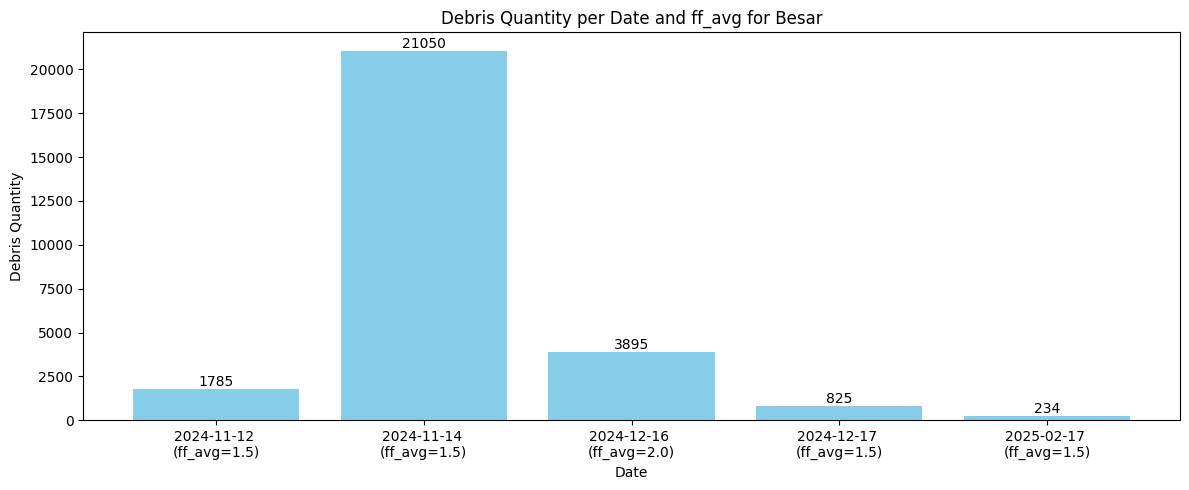

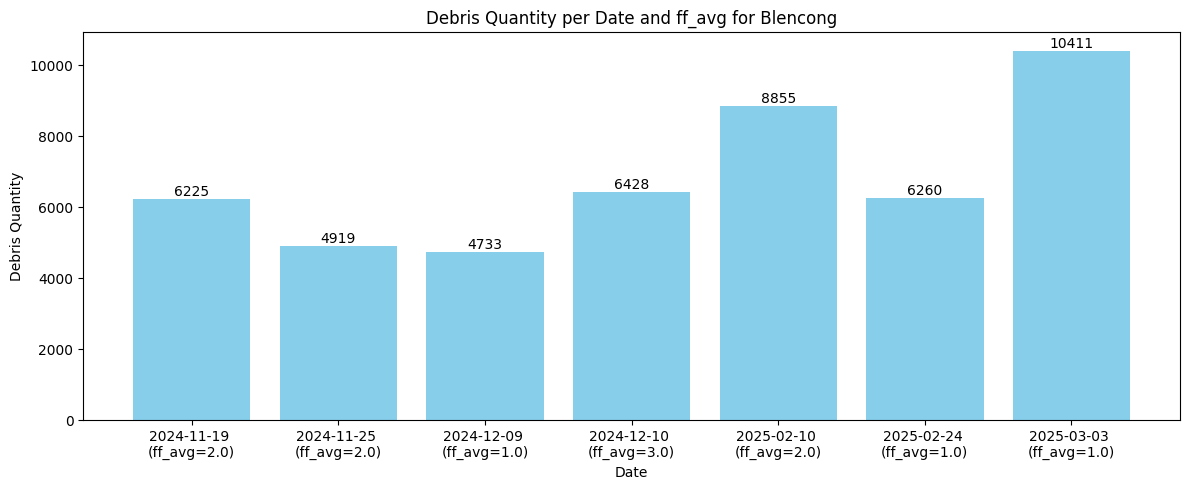

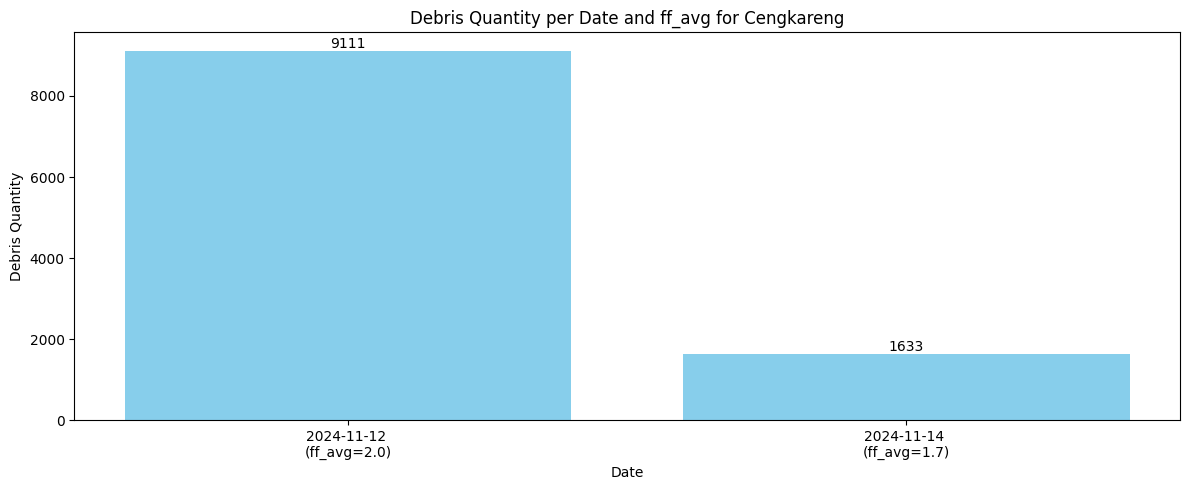

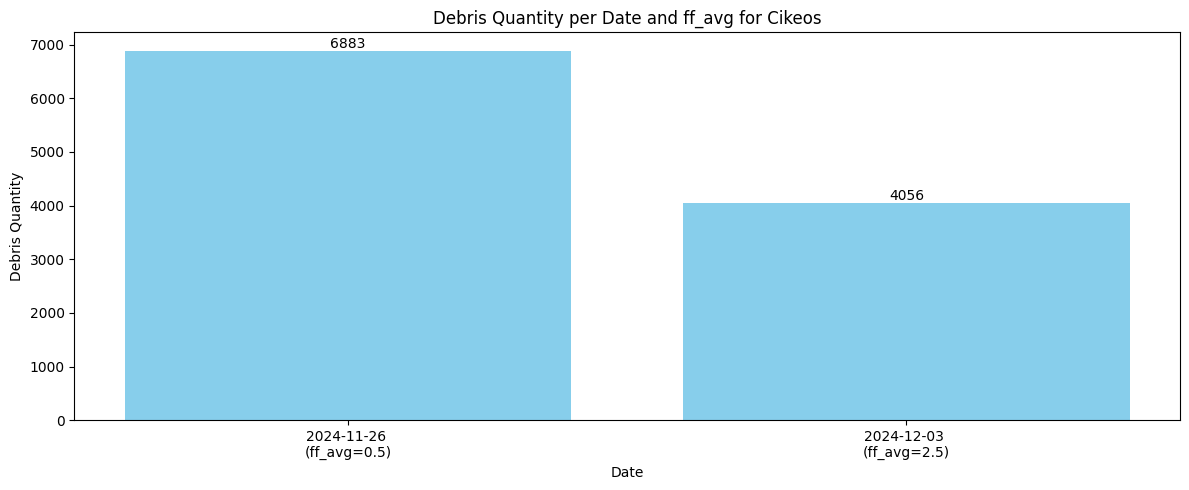

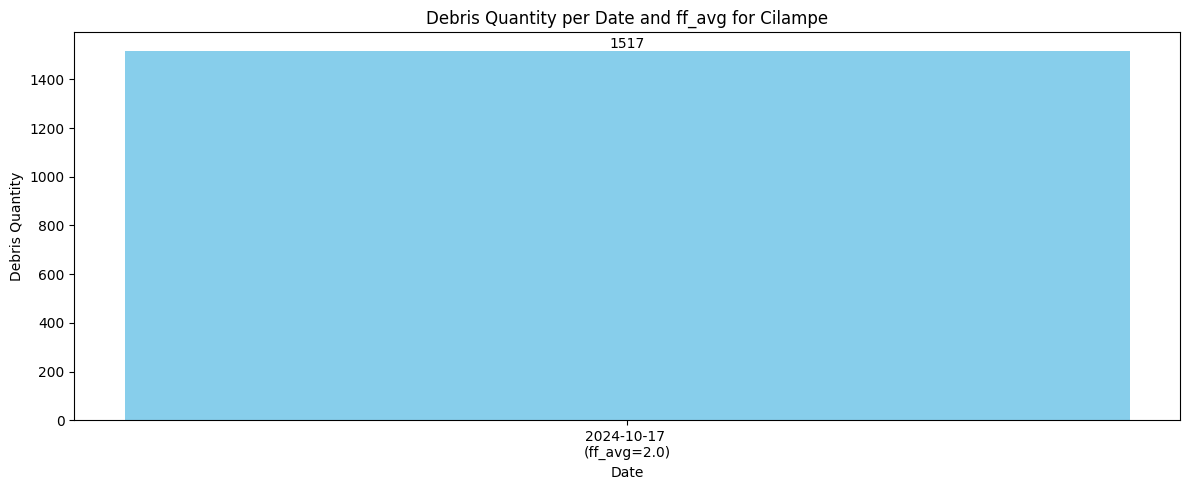

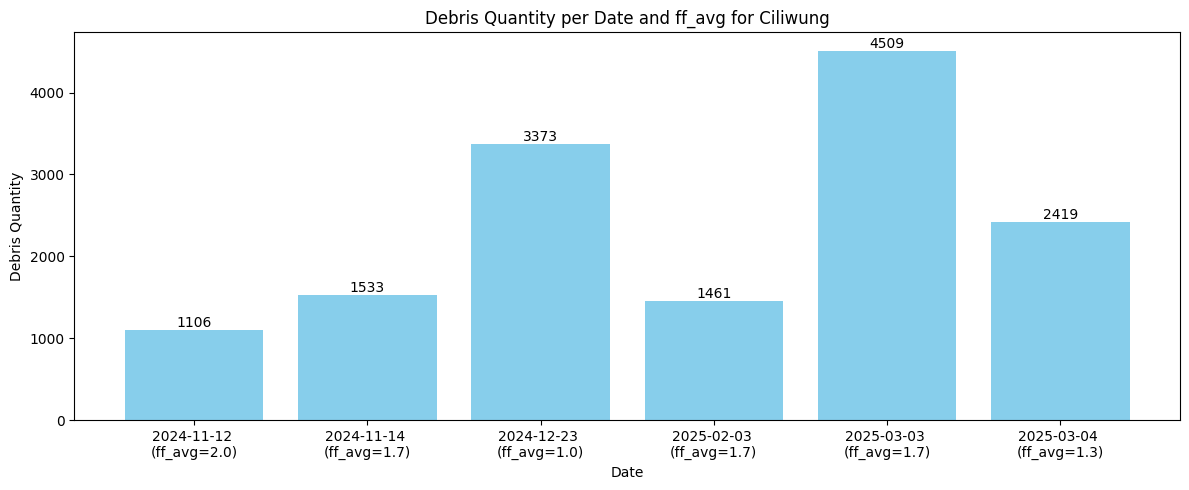

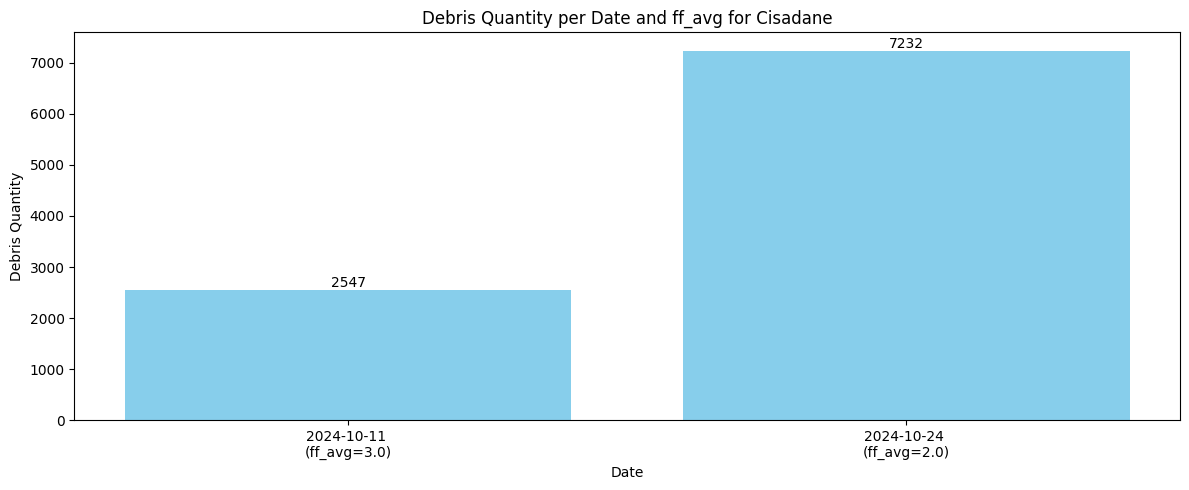

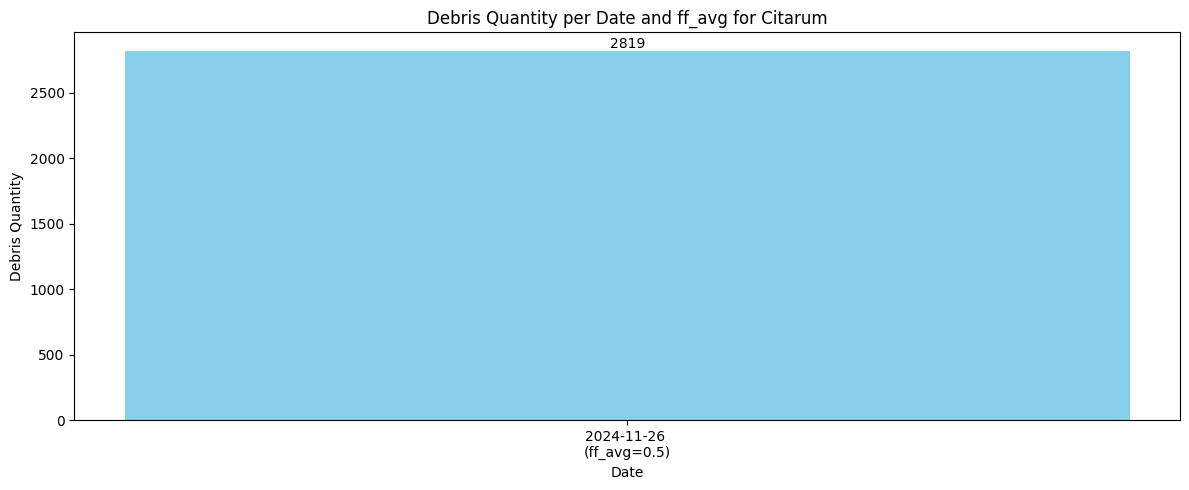

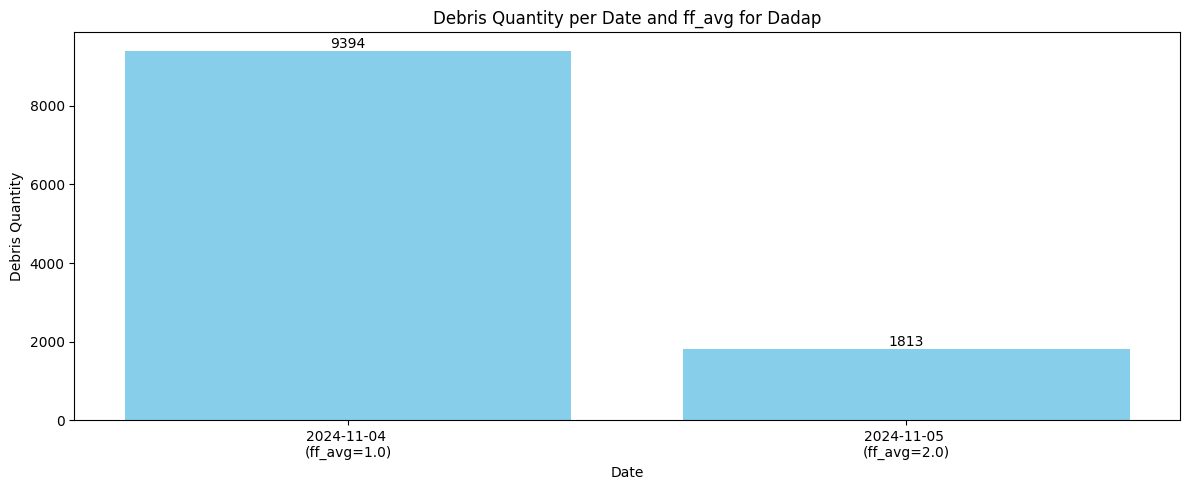

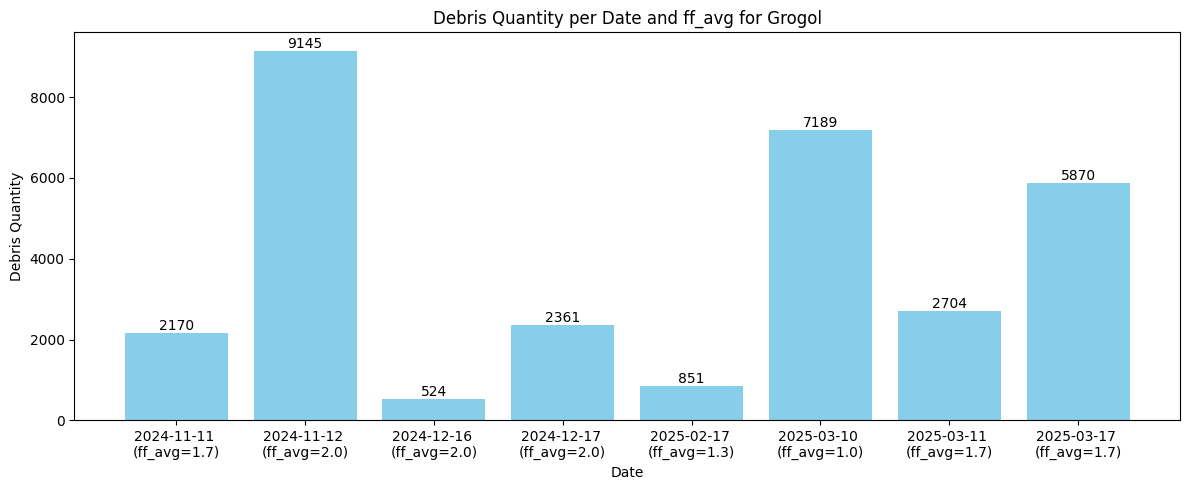

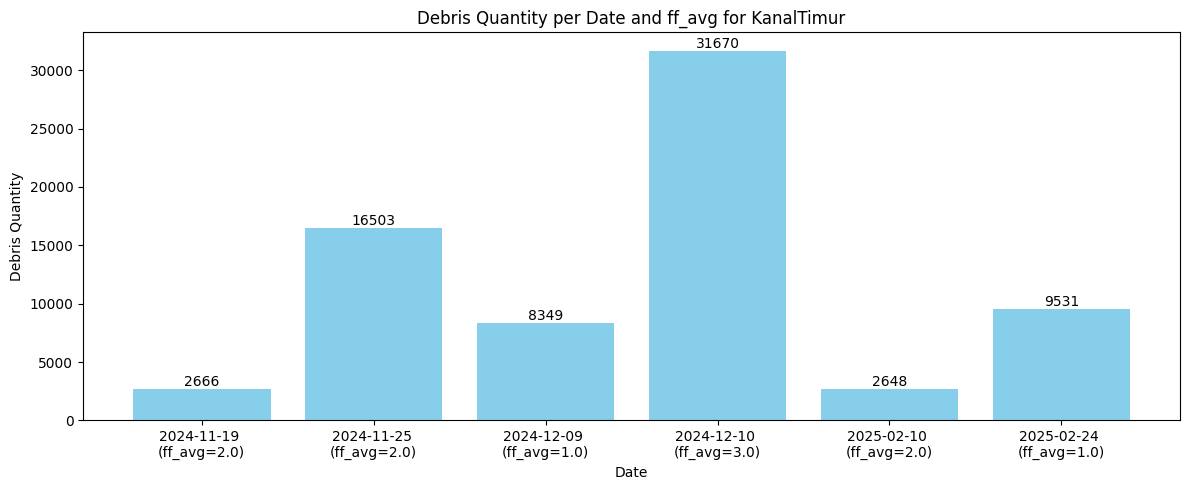

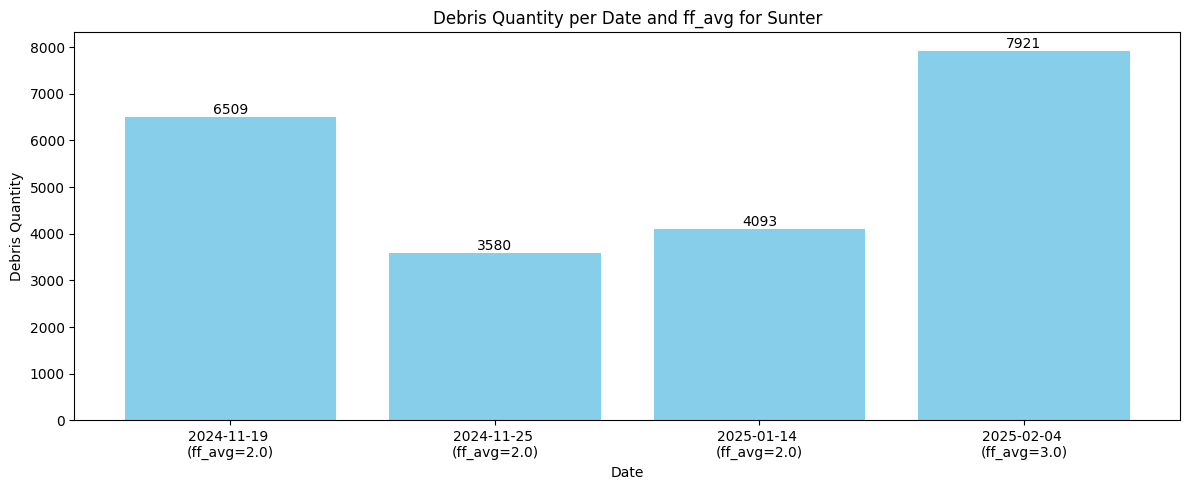

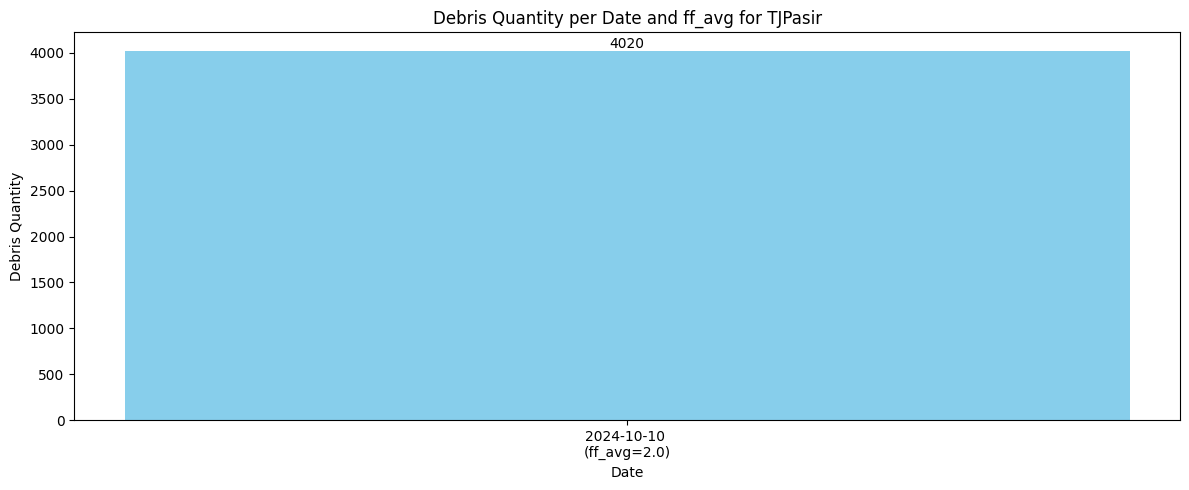

In [13]:
# Suppose your DataFrame is called river_comparison
# and has columns: 'date', 'wind_class', 'ff_avg', 'Cisadane', 'Besar', ...

for river in ['Besar', 'Blencong', 'Cengkareng', 'Cikeos', 'Cilampe', 'Ciliwung', 'Cisadane', 'Citarum', 'Dadap', 'Grogol', 'KanalTimur', 'Sunter', 'TJPasir']:
    if river in river_comparison.columns:
        river_data = river_comparison[['date', 'wind_class', 'ff_avg', river]].dropna(subset=[river])
        # Create a combined x label with date and ff_avg
        x_labels = river_data.apply(lambda row: f"{row['date']} \n(ff_avg={row['ff_avg']:.1f})", axis=1)
        debris_quantity = river_data[river]
        y = debris_quantity

        plt.figure(figsize=(12, 5))
        bars = plt.bar(x_labels, y, color='skyblue')

        for bar, dq in zip(bars, debris_quantity):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f'{dq:.0f}' if pd.notnull(dq) else '',
                ha='center',
                va='bottom',
                fontsize=10,
                rotation=0  # horizontal
            )

        plt.title(f'Debris Quantity per Date and ff_avg for {river}')
        plt.xlabel('Date')
        plt.ylabel('Debris Quantity')
        # plt.xticks(rotation=0, ha='right')
        plt.tight_layout()
        plt.show()

# Question 2

Bagaimana pengaruh pasang surut terhadap jumlah sampah di sungai? Apakah saat air pasang, jumlah sampah cenderung meningkat atau menurun?

  Tides  count         mean  median          std
0  High     20  7507.400000  4826.0  7394.739712
1   Low     36  5529.583333  3476.5  6084.359022


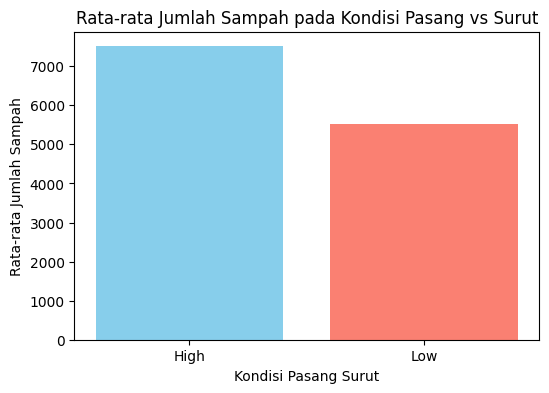

<Figure size 800x500 with 0 Axes>

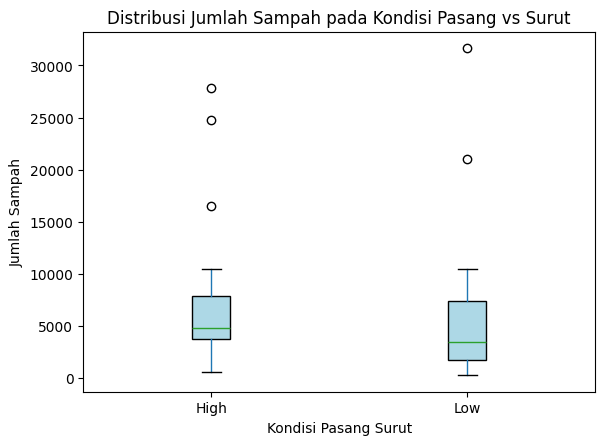

In [14]:
import matplotlib.pyplot as plt

# 1. Kelompokkan data berdasarkan kondisi pasang surut
tides_summary = ds.groupby('Tides')['Debri Quantity'].agg(['count', 'mean', 'median', 'std']).reset_index()
print(tides_summary)

# 2. Visualisasi rata-rata jumlah sampah pada saat pasang vs surut
plt.figure(figsize=(6,4))
plt.bar(tides_summary['Tides'], tides_summary['mean'], color=['skyblue', 'salmon'])
plt.xlabel('Kondisi Pasang Surut')
plt.ylabel('Rata-rata Jumlah Sampah')
plt.title('Rata-rata Jumlah Sampah pada Kondisi Pasang vs Surut')
plt.show()

# 3. Boxplot untuk distribusi lebih detail
plt.figure(figsize=(8,5))
ds.boxplot(column='Debri Quantity', by='Tides', grid=False, patch_artist=True,
           boxprops=dict(facecolor='lightblue'))
plt.xlabel('Kondisi Pasang Surut')
plt.ylabel('Jumlah Sampah')
plt.title('Distribusi Jumlah Sampah pada Kondisi Pasang vs Surut')
plt.suptitle('')
plt.show()

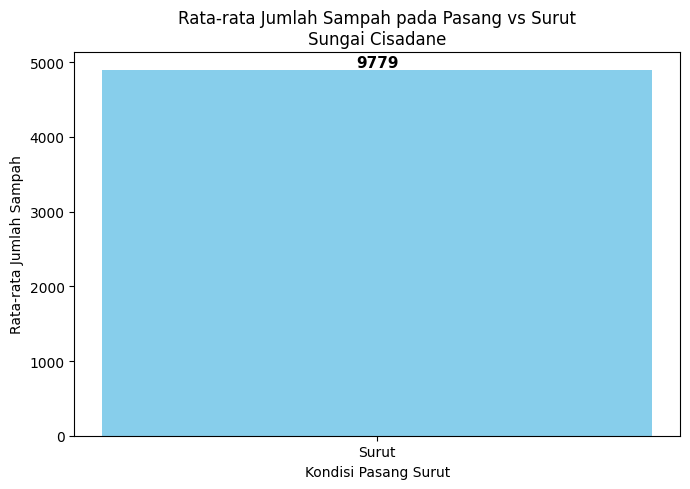

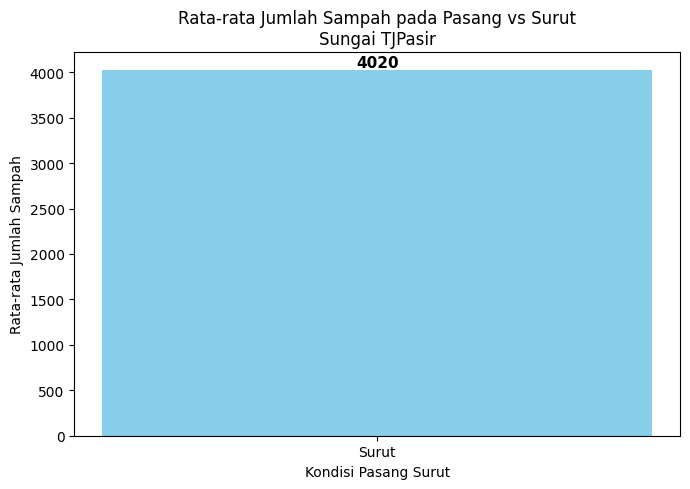

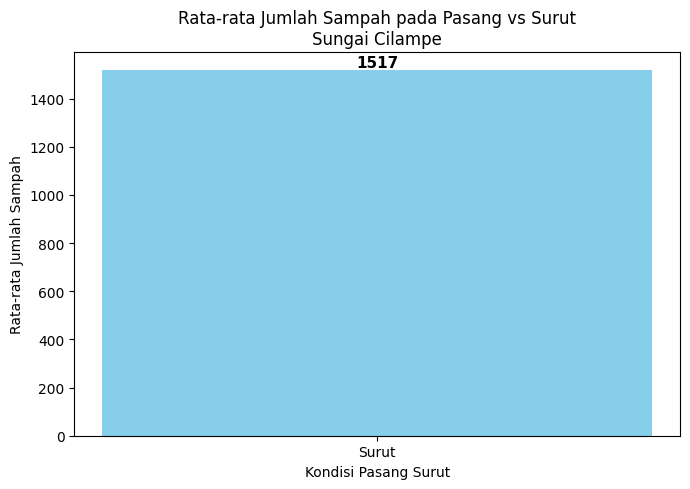

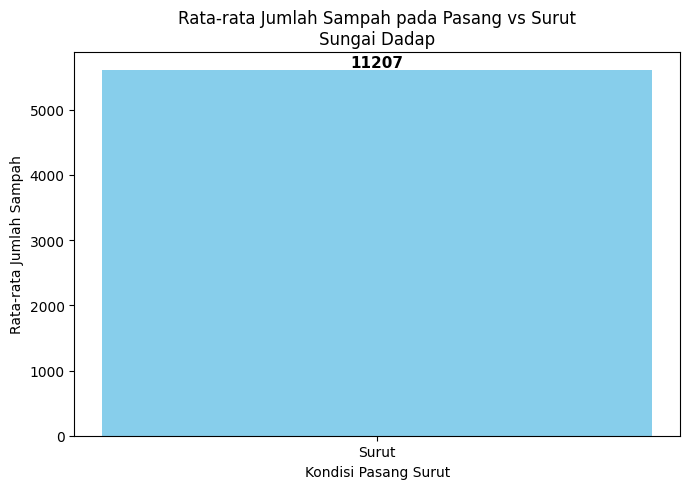

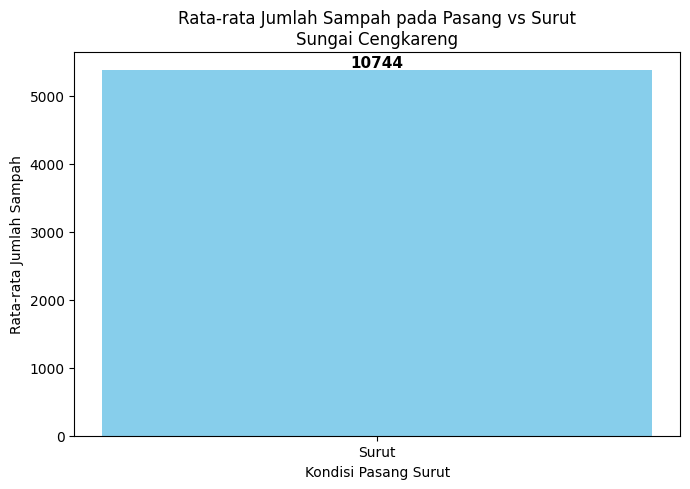

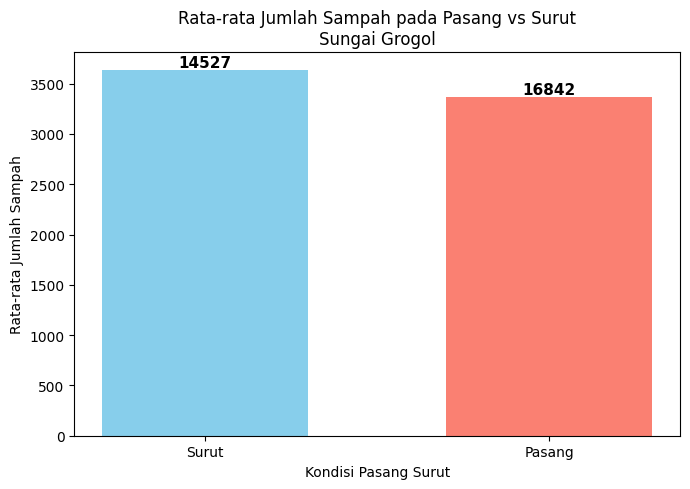

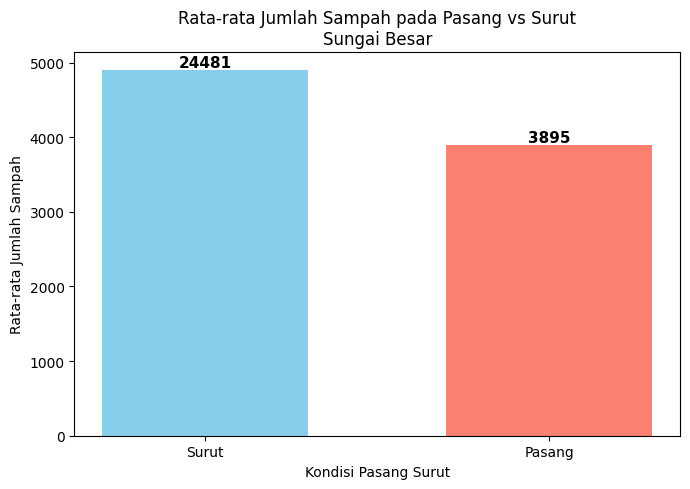

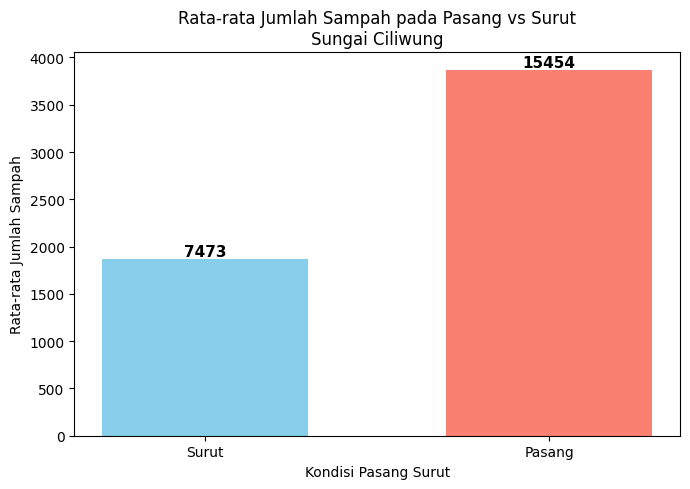

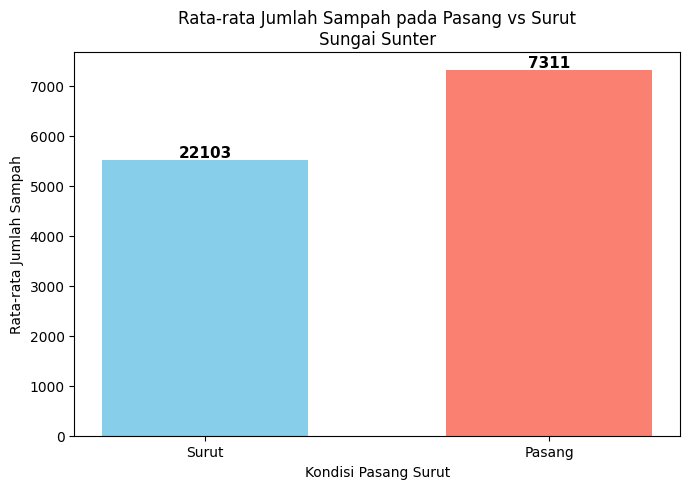

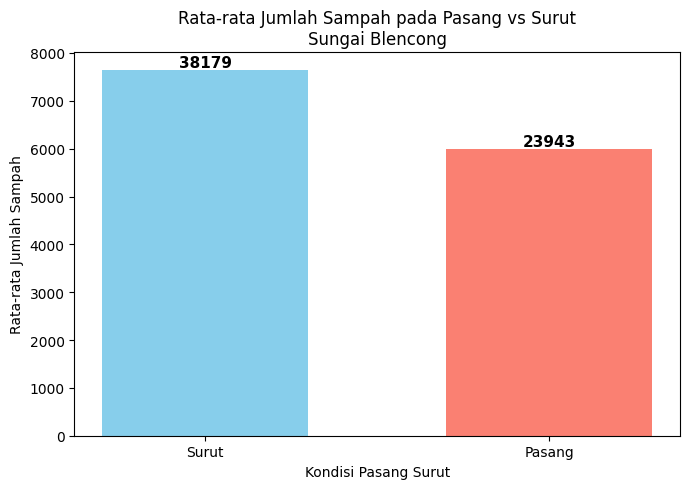

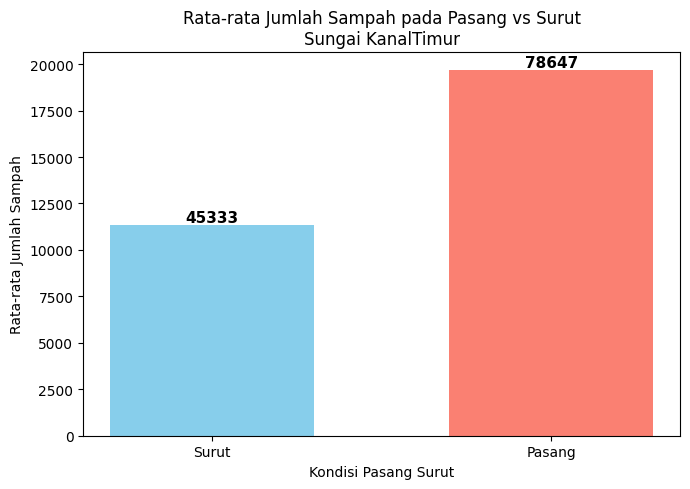

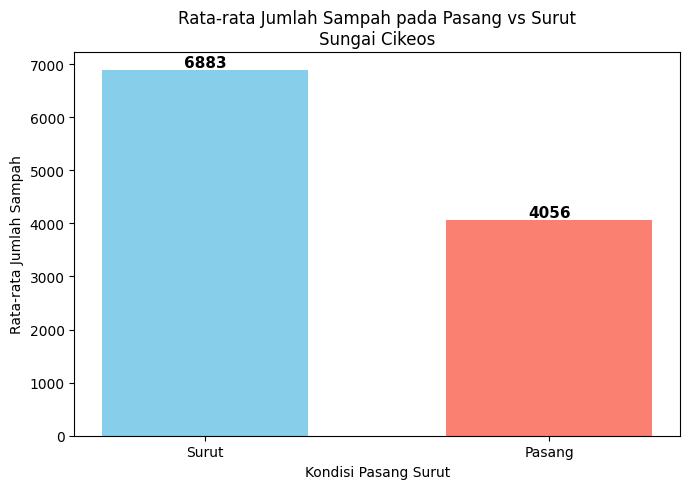

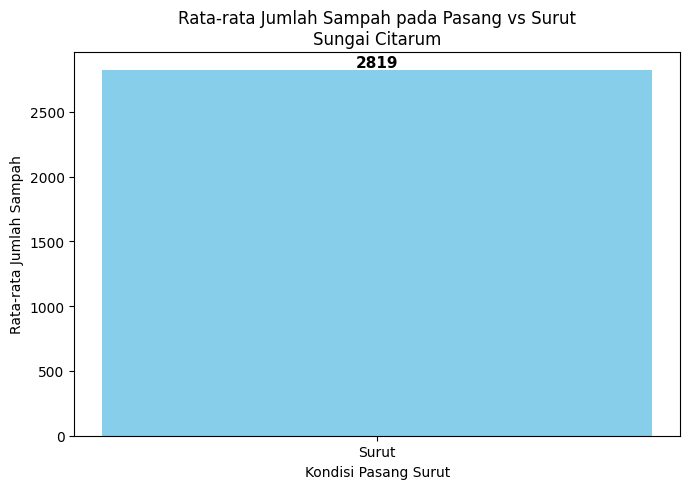

In [15]:
for river in ds['Name'].unique():
    subset = ds[ds['Name'] == river]
    # Hitung rata-rata Debri Quantity untuk masing-masing kondisi pasang surut
    tides_means = subset.groupby('Tides')['Debri Quantity'].mean()
    tides_sums = subset.groupby('Tides')['Debri Quantity'].sum()
    # Pastikan urutan bar: Low, High (atau Surut, Pasang)
    tides_order = ['Low', 'High'] if set(['Low', 'High']).issubset(tides_means.index) else list(tides_means.index)
    values = [tides_means.get(tide, 0) for tide in tides_order]
    sums = [tides_sums.get(tide, 0) for tide in tides_order]
    x = range(len(tides_order))
    plt.figure(figsize=(7,5))
    bars = plt.bar(x, values, color=['skyblue', 'salmon'], width=0.6)
    plt.xticks(x, ['Surut' if t=='Low' else 'Pasang' for t in tides_order])
    plt.xlabel('Kondisi Pasang Surut')
    plt.ylabel('Rata-rata Jumlah Sampah')
    plt.title(f'Rata-rata Jumlah Sampah pada Pasang vs Surut\nSungai {river}')
    # Tambahkan angka pada puncak bar (jumlah total debris quantity)
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{int(sums[i])}', 
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.tight_layout()
    plt.show()

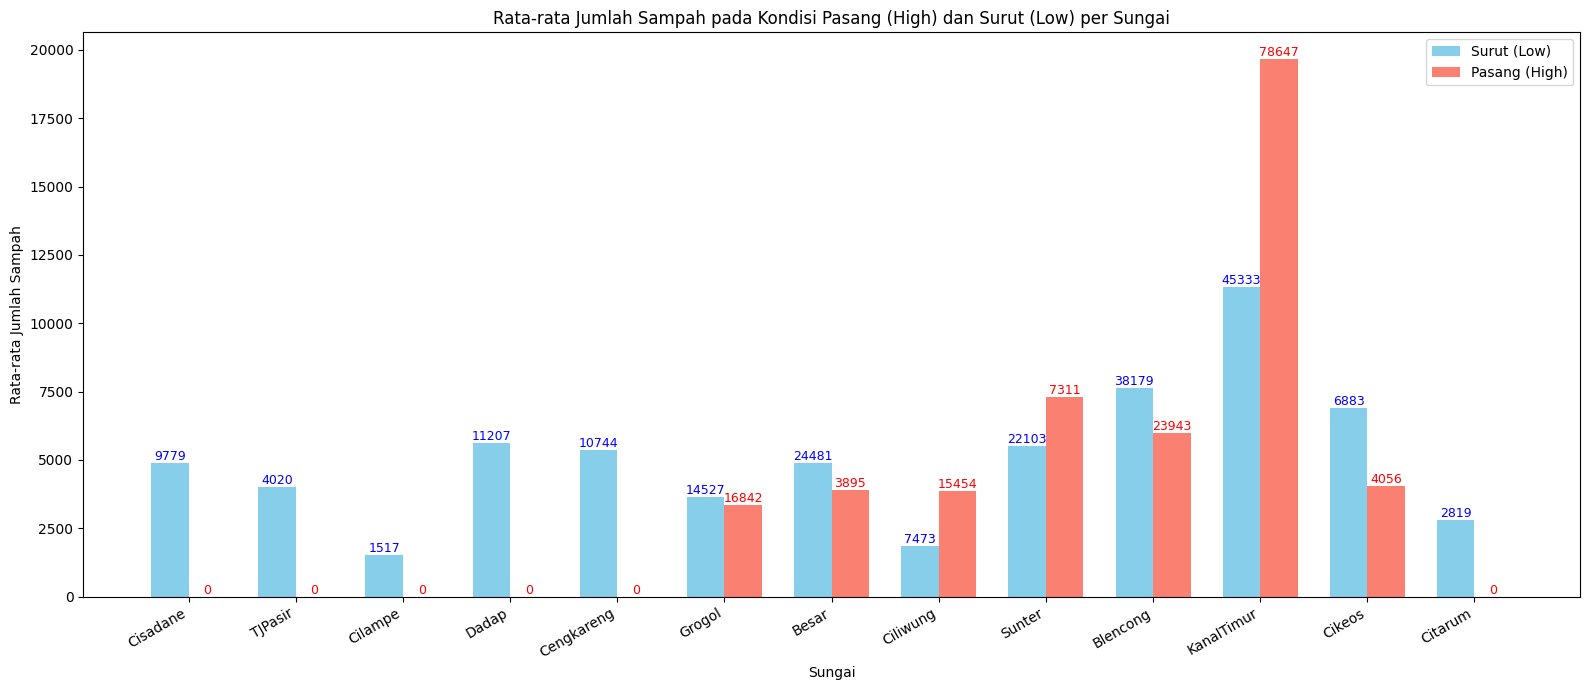

In [16]:
# Visualisasi perbandingan rata-rata jumlah sampah pada kondisi pasang (High) dan surut (Low) untuk setiap sungai dalam satu figure
# Siapkan data summary per sungai dan kondisi pasang surut
summary = ds.groupby(['Name', 'Tides'])['Debri Quantity'].agg(['mean', 'sum', 'count']).reset_index()

# Pastikan urutan sungai konsisten
rivers = ds['Name'].unique()
tides_order = ['Low', 'High']

# Siapkan data untuk plot
means_low = []
means_high = []
sums_low = []
sums_high = []
counts_low = []
counts_high = []

for river in rivers:
    # Ambil data untuk sungai ini
    river_data = summary[summary['Name'] == river]
    # Mean
    mean_low = river_data[river_data['Tides'] == 'Low']['mean'].values
    mean_high = river_data[river_data['Tides'] == 'High']['mean'].values
    means_low.append(mean_low[0] if len(mean_low) > 0 else 0)
    means_high.append(mean_high[0] if len(mean_high) > 0 else 0)
    # Sum
    sum_low = river_data[river_data['Tides'] == 'Low']['sum'].values
    sum_high = river_data[river_data['Tides'] == 'High']['sum'].values
    sums_low.append(sum_low[0] if len(sum_low) > 0 else 0)
    sums_high.append(sum_high[0] if len(sum_high) > 0 else 0)
    # Count
    count_low = river_data[river_data['Tides'] == 'Low']['count'].values
    count_high = river_data[river_data['Tides'] == 'High']['count'].values
    counts_low.append(count_low[0] if len(count_low) > 0 else 0)
    counts_high.append(count_high[0] if len(count_high) > 0 else 0)

x = np.arange(len(rivers))  # posisi x untuk setiap sungai
width = 0.35  # lebar bar

plt.figure(figsize=(16, 7))
bars1 = plt.bar(x - width/2, means_low, width, label='Surut (Low)', color='skyblue')
bars2 = plt.bar(x + width/2, means_high, width, label='Pasang (High)', color='salmon')

plt.xticks(x, rivers, rotation=30, ha='right')
plt.xlabel('Sungai')
plt.ylabel('Rata-rata Jumlah Sampah')
plt.title('Rata-rata Jumlah Sampah pada Kondisi Pasang (High) dan Surut (Low) per Sungai')
plt.legend()

# Tambahkan angka total (sum) di atas bar
for i, (bar_low, bar_high) in enumerate(zip(bars1, bars2)):
    # Untuk bar Low
    plt.text(bar_low.get_x() + bar_low.get_width()/2, bar_low.get_height(), 
             f'{int(sums_low[i])}', ha='center', va='bottom', fontsize=9, color='blue')
    # Untuk bar High
    plt.text(bar_high.get_x() + bar_high.get_width()/2, bar_high.get_height(), 
             f'{int(sums_high[i])}', ha='center', va='bottom', fontsize=9, color='red')

plt.tight_layout()
plt.show()


# Question 3

Apakah ada pola penumpukan sampah di sungai tertentu yang dipengaruhi oleh pergerakan pasut?

In [17]:
correlations = []
for river in ds['Name'].unique():
    subset = ds[ds['Name'] == river]
    if subset['Tides in Number'].nunique() > 1:  # avoid error if only one value
        corr = subset['Tides in Number'].corr(subset['Debri Quantity'])
        correlations.append({'Name': river, 'Correlation': corr})

corr_df = pd.DataFrame(correlations)
print(corr_df.sort_values('Correlation', ascending=False))

# Korelasi antara "Tides in Number" (angka pasang surut, semakin besar berarti semakin pasang) dan "Debri Quantity" (jumlah sampah) menunjukkan hubungan linier antara kedua variabel tersebut untuk setiap sungai.
# 
# Nilai korelasi (Pearson correlation coefficient) berkisar antara -1 hingga 1:
# - Jika nilainya positif (mendekati 1), artinya semakin tinggi angka pasang (misal, semakin pasang), maka jumlah sampah cenderung bertambah. 
# - Jika nilainya negatif (mendekati -1), artinya semakin tinggi angka pasang, jumlah sampah justru cenderung berkurang (atau sebaliknya, saat surut sampah lebih banyak).
# - Jika nilainya mendekati 0, artinya tidak ada hubungan linier yang kuat antara pasang surut dan jumlah sampah.
# 
# Berikut adalah hasil analisis korelasi antara pasang surut dan jumlah sampah untuk masing-masing sungai:
print("\n Interpretasi Korelasi Pasang Surut dan Jumlah Sampah per Sungai:\n")
for idx, row in corr_df.sort_values('Correlation', ascending=False).iterrows():
    river = row['Name']
    corr = row['Correlation']
    if pd.isna(corr):
        desc = "Data tidak cukup untuk analisis korelasi."
    elif corr > 0.5:
        desc = "Korelasi positif kuat: Saat pasang naik, jumlah sampah cenderung meningkat."
    elif corr > 0.2:
        desc = "Korelasi positif lemah: Ada kecenderungan jumlah sampah meningkat saat pasang naik."
    elif corr < -0.5:
        desc = "Korelasi negatif kuat: Saat pasang naik, jumlah sampah cenderung menurun."
    elif corr < -0.2:
        desc = "Korelasi negatif lemah: Ada kecenderungan jumlah sampah menurun saat pasang naik."
    else:
        desc = "Tidak ada korelasi linier yang kuat antara pasang surut dan jumlah sampah."
    print(f"Sungai {river}: Korelasi = {corr:.2f}. {desc}")

         Name  Correlation
0       Dadap     1.000000
3    Ciliwung     0.669181
6  KanalTimur     0.414917
4      Sunter     0.258344
1      Grogol     0.079332
5    Blencong    -0.138843
2       Besar    -0.279357
7      Cikeos    -1.000000

 Interpretasi Korelasi Pasang Surut dan Jumlah Sampah per Sungai:

Sungai Dadap: Korelasi = 1.00. Korelasi positif kuat: Saat pasang naik, jumlah sampah cenderung meningkat.
Sungai Ciliwung: Korelasi = 0.67. Korelasi positif kuat: Saat pasang naik, jumlah sampah cenderung meningkat.
Sungai KanalTimur: Korelasi = 0.41. Korelasi positif lemah: Ada kecenderungan jumlah sampah meningkat saat pasang naik.
Sungai Sunter: Korelasi = 0.26. Korelasi positif lemah: Ada kecenderungan jumlah sampah meningkat saat pasang naik.
Sungai Grogol: Korelasi = 0.08. Tidak ada korelasi linier yang kuat antara pasang surut dan jumlah sampah.
Sungai Blencong: Korelasi = -0.14. Tidak ada korelasi linier yang kuat antara pasang surut dan jumlah sampah.
Sungai Besar: Korel

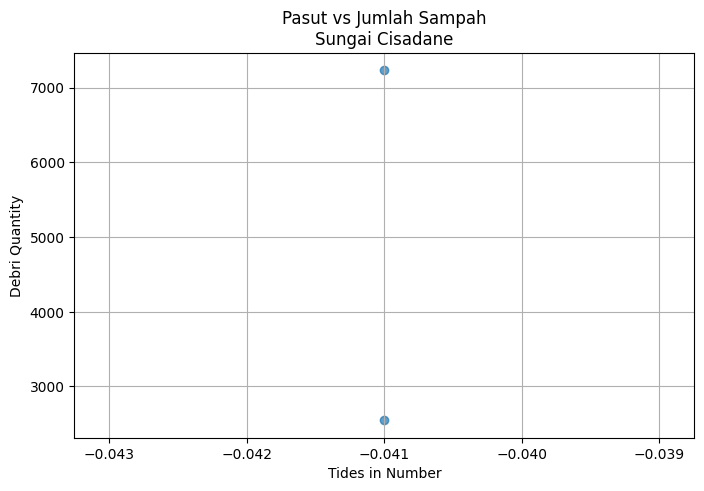

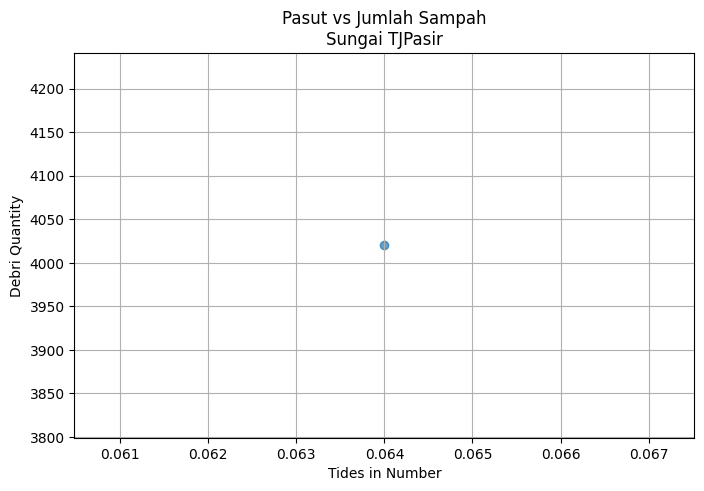

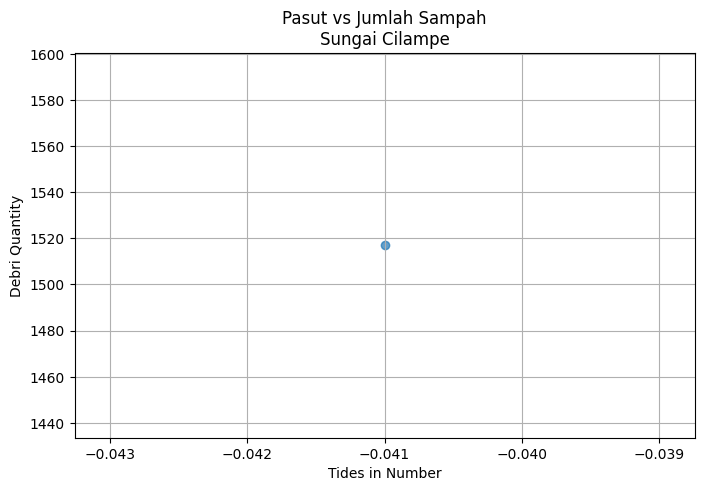

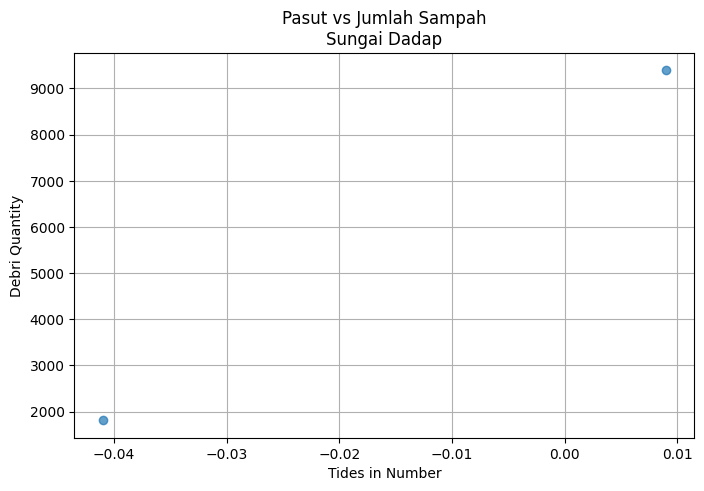

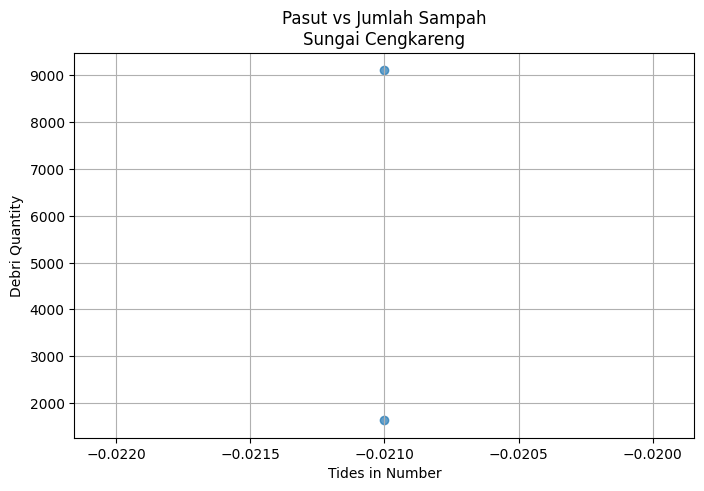

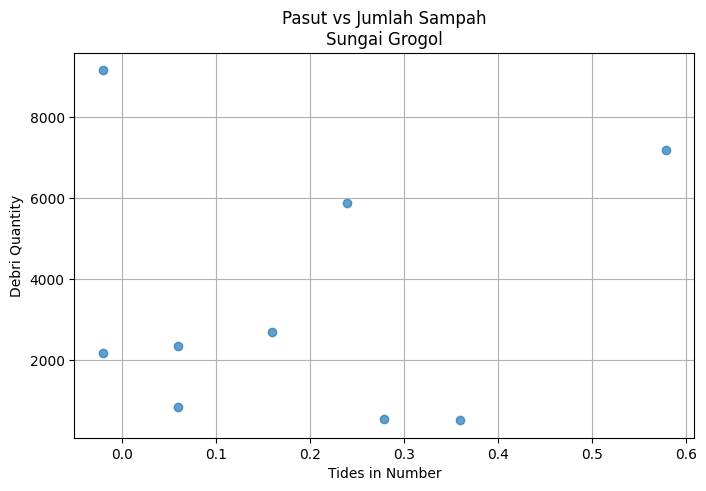

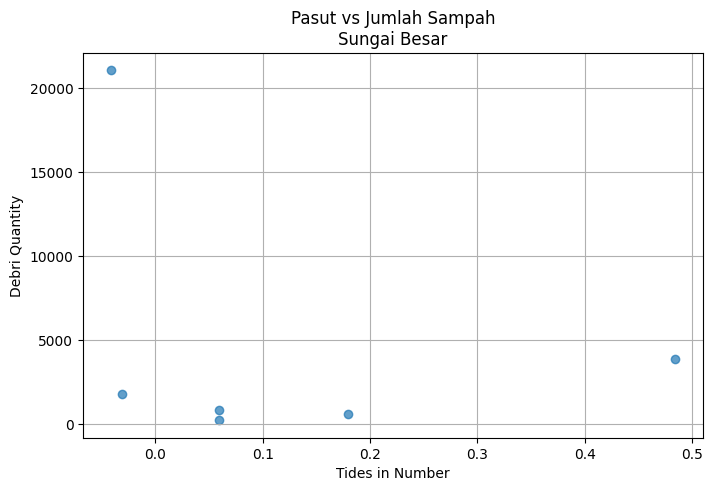

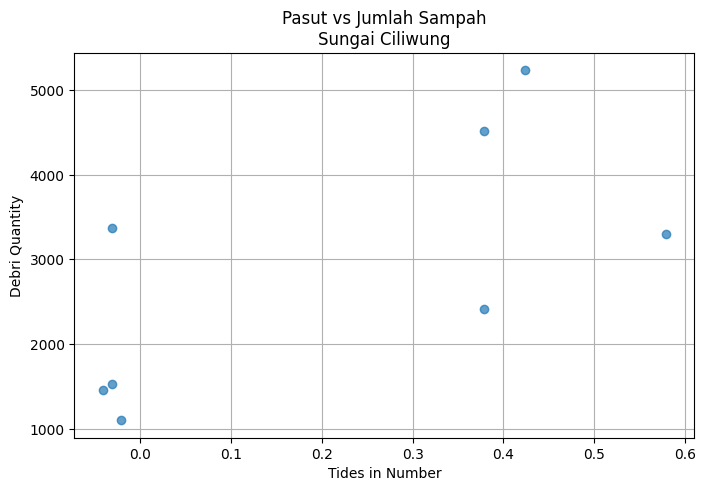

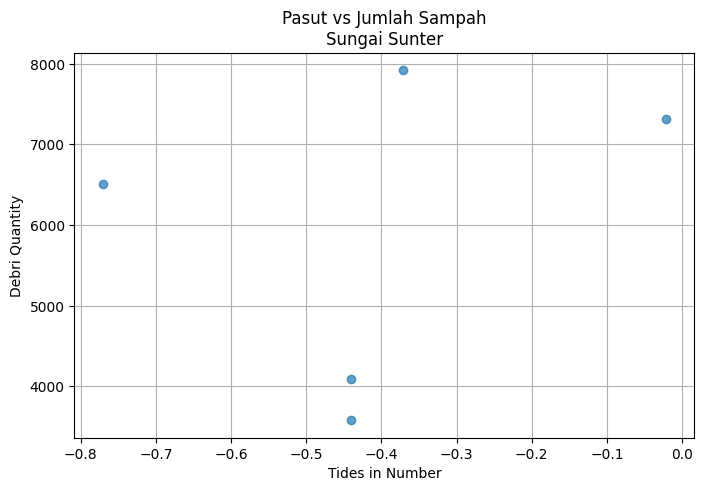

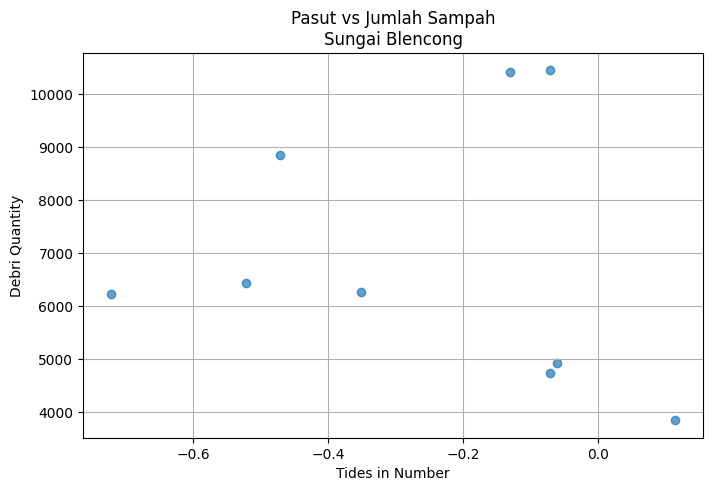

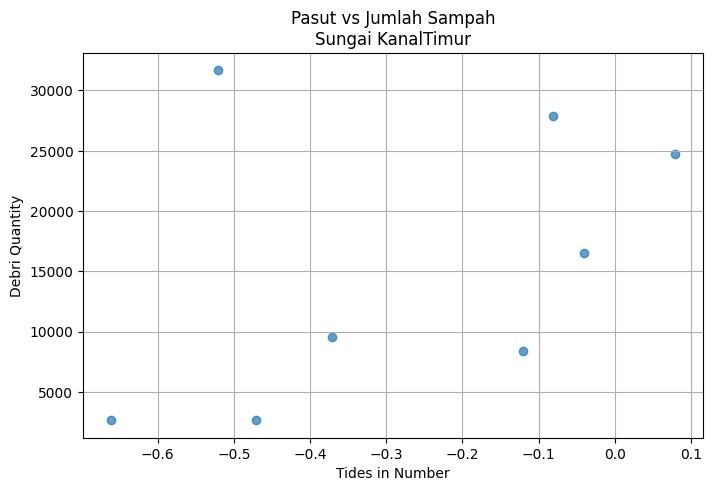

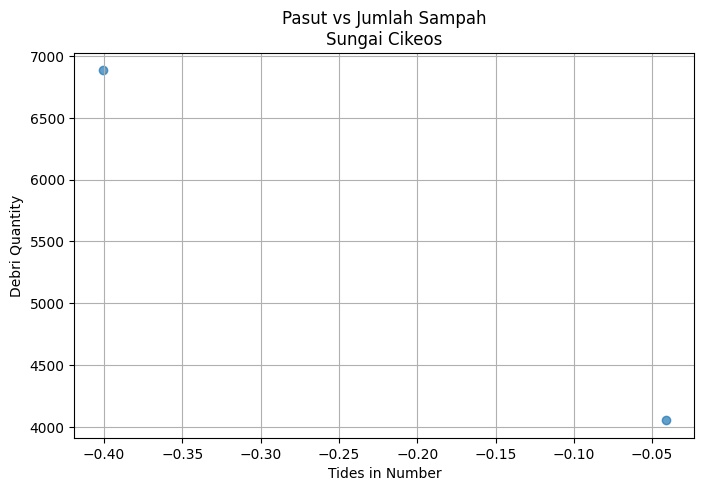

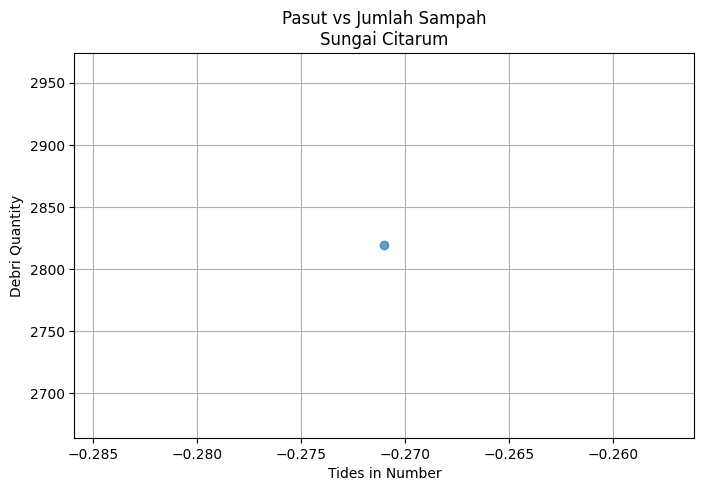

In [18]:
for river in ds['Name'].unique():
    subset = ds[ds['Name'] == river]
    plt.figure(figsize=(8,5))
    plt.scatter(subset['Tides in Number'], subset['Debri Quantity'], alpha=0.7)
    plt.title(f'Pasut vs Jumlah Sampah\nSungai {river}')
    plt.xlabel('Tides in Number')
    plt.ylabel('Debri Quantity')
    plt.grid(True)
    plt.show()

C:\Users\Fathur\AppData\Local\Temp\ipykernel_7788\2380270908.py:24: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(subset['Tides in Number'].dropna(),
c:\Users\Fathur\.pyenv\pyenv-win\versions\3.11.7\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Fathur\.pyenv\pyenv-win\versions\3.11.7\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\Fathur\AppData\Local\Temp\ipykernel_7788\2380270908.py:24: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(subset['Tides in Number'].dropna(),


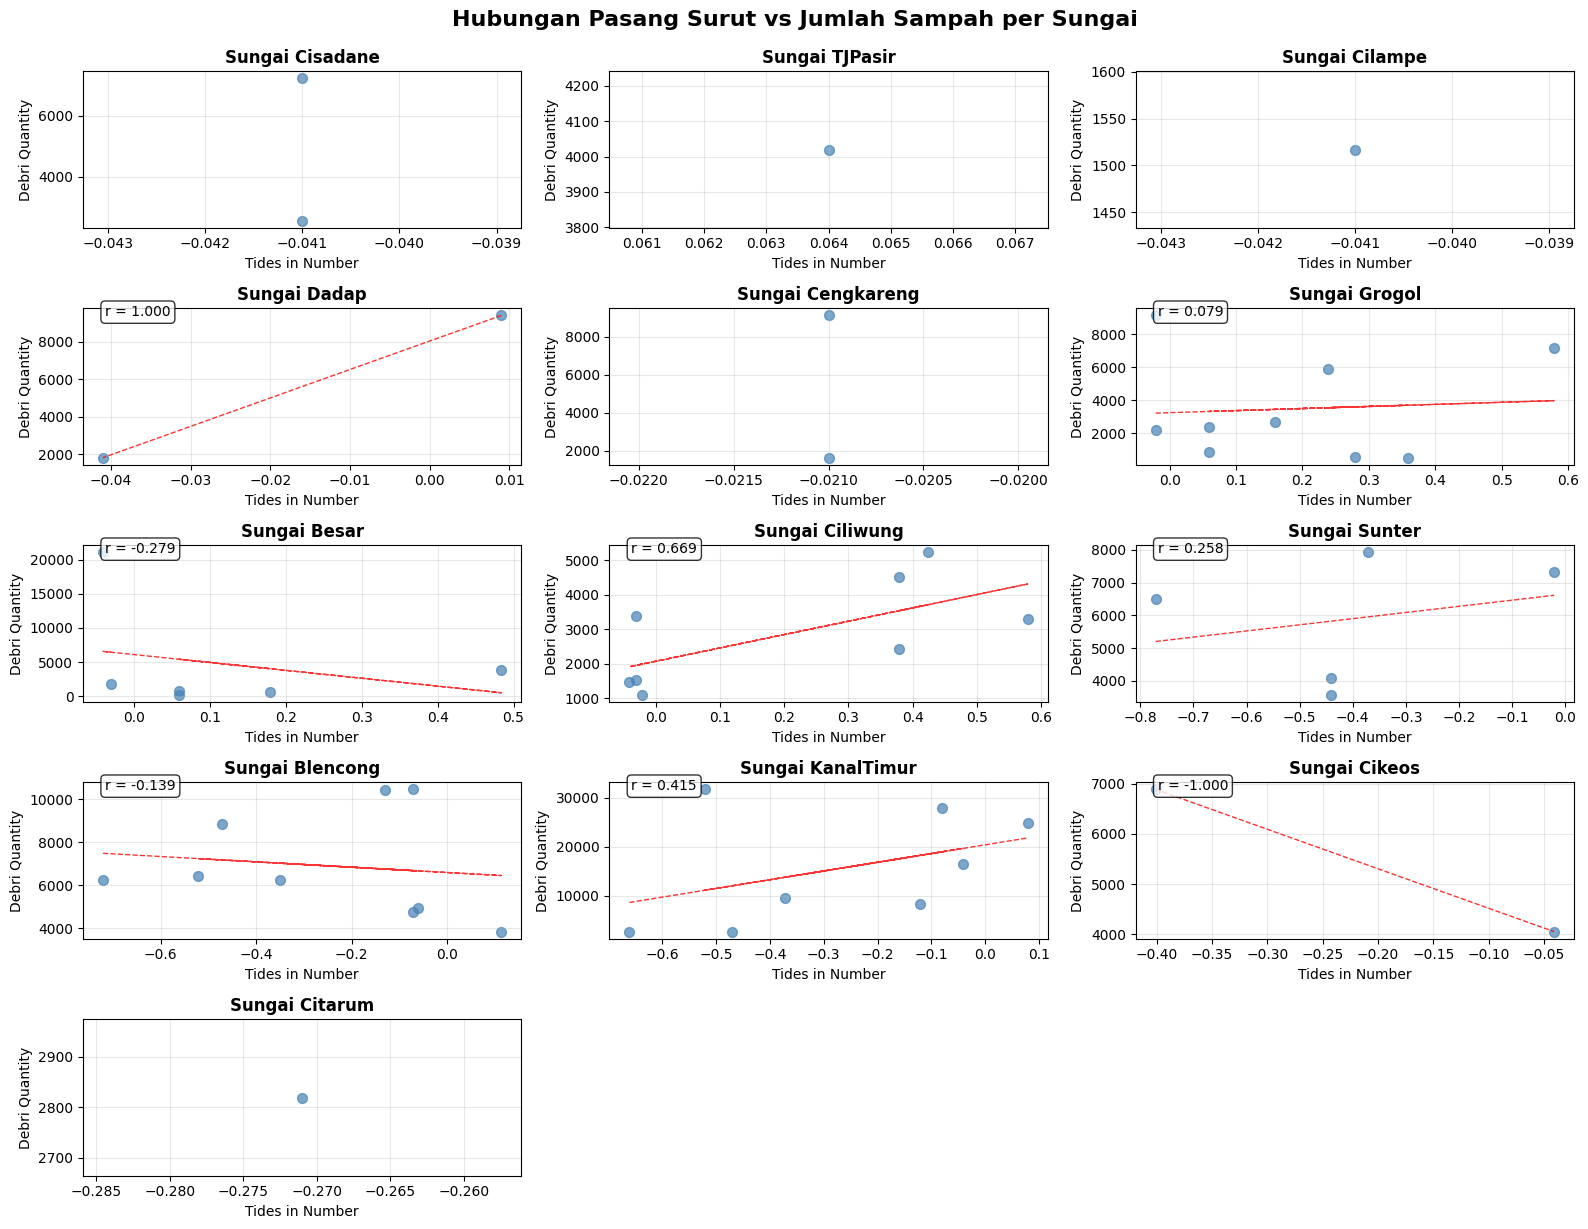

In [19]:
# Visualization
plt.figure(figsize=(16, 12))

# Get unique rivers
rivers = ds['Name'].unique()
n_rivers = len(rivers)

# Calculate subplot layout
cols = 3
rows = (n_rivers + cols - 1) // cols  # Ceiling division

for i, river in enumerate(rivers):
    subset = ds[ds['Name'] == river]
    
    # Create subplot
    plt.subplot(rows, cols, i + 1)
    
    # Scatter plot
    plt.scatter(subset['Tides in Number'], subset['Debri Quantity'], 
                alpha=0.7, s=50, color='steelblue')
    
    # Add trend line if enough data points
    if len(subset) > 1:
        z = np.polyfit(subset['Tides in Number'].dropna(), 
                      subset['Debri Quantity'].dropna(), 1)
        p = np.poly1d(z)
        plt.plot(subset['Tides in Number'], p(subset['Tides in Number']), 
                "r--", alpha=0.8, linewidth=1)
    
    plt.title(f'Sungai {river}', fontsize=12, fontweight='bold')
    plt.xlabel('Tides in Number')
    plt.ylabel('Debri Quantity')
    plt.grid(True, alpha=0.3)
    
    # Add correlation coefficient as text
    if len(subset) > 1:
        corr = subset['Tides in Number'].corr(subset['Debri Quantity'])
        if not pd.isna(corr):
            plt.text(0.05, 0.95, f'r = {corr:.3f}', 
                    transform=plt.gca().transAxes, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                    fontsize=10)

plt.tight_layout()
plt.suptitle('Hubungan Pasang Surut vs Jumlah Sampah per Sungai', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Question 4

In [20]:
df_all.head(25)

,date,Name,station,ff_avg,wind_class,Debri Quantity,Organic Quantity,Plastic Quantity,rr_3days
0,2024-10-11,Cisadane,Bogor,3.0,tenang,2547,588,1959,"[0.0, 1.2, 3.5, 14.2]"
1,2024-10-11,Cisadane,Priok,3.0,tenang,2547,588,1959,"[0.0, 0.0, 0.0, 0.0]"
2,2024-10-24,Cisadane,Bogor,2.0,tenang,7232,1179,6053,"[0.0, 0.0, 0.0, 0.0]"
3,2024-10-24,Cisadane,Priok,2.0,tenang,7232,1179,6053,"[0.0, 0.0, 0.0, 23.2]"
4,2024-10-10,TJPasir,Priok,2.0,tenang,4020,1840,2180,"[0.0, 0.0, 0.0, 0.0]"
5,2024-10-17,Cilampe,Priok,2.0,tenang,1517,210,1307,"[0.0, 0.0, 1.0, 0.6]"
6,2024-11-04,Dadap,Priok,1.0,tenang,9394,989,8405,"[0.0, 0.0, 0.3, 3.4]"
7,2024-11-05,Dadap,Priok,2.0,tenang,1813,458,1355,"[0.0, 0.3, 3.4]"
8,2024-11-12,Cengkareng,Priok,2.0,tenang,9111,2462,6649,"[0.0, 0.0, 2.5]"
9,2024-11-12,Cengkareng,Kemayoran,1.0,tenang,9111,2462,6649,"[0.0, 0.0, 0.0, 5.6]"


In [21]:
# Analisis korelasi antara curah hujan (3 hari) dan jumlah sampah di sungai
# Data curah hujan sudah tersedia dalam DataFrame bernama df_all,
# yang berisi kolom: date, Name, station, ff_avg, wind_class, Debri Quantity, Organic Quantity, Plastic Quantity, rr_3days
# Kolom rr_3days adalah list curah hujan 3 hari sebelum hingga hari H (bisa 3 atau 4 elemen, tergantung data)

# Kita akan hitung total curah hujan 3 hari (atau 4 hari jika ada) sebelum pengambilan data,
# lalu analisis korelasi dengan Debri Quantity.

# 1. Hitung total curah hujan 3 hari (atau 4 hari) untuk setiap baris
def sum_rain(rr_list):
    if isinstance(rr_list, list):
        return sum([float(x) for x in rr_list if x is not None])
    elif isinstance(rr_list, str):
        # Jika string, coba eval ke list
        import ast
        try:
            l = ast.literal_eval(rr_list)
            return sum([float(x) for x in l if x is not None])
        except:
            return None
    else:
        return None

df_all['rain_3days_sum'] = df_all['rr_3days'].apply(sum_rain)

# 2. Buat DataFrame perbandingan
comparison_df = df_all[['date', 'Name', 'station', 'rain_3days_sum', 'Debri Quantity']].copy()

# 3. Tampilkan tabel comparison
print("\nTabel Perbandingan Curah Hujan 3 Hari dan Jumlah Sampah Sungai:")
display(comparison_df.head(20))

# 4. Hitung korelasi Pearson antara total curah hujan 3 hari dan jumlah sampah (hanya data yang ada)
valid_corr = comparison_df.dropna(subset=['rain_3days_sum', 'Debri Quantity'])
corr = valid_corr['rain_3days_sum'].corr(valid_corr['Debri Quantity'])
print(f"\nKorelasi Pearson antara total curah hujan 3 hari dan jumlah sampah sungai (seluruh data): {corr:.2f}")


Tabel Perbandingan Curah Hujan 3 Hari dan Jumlah Sampah Sungai:


,date,Name,station,rain_3days_sum,Debri Quantity
0,2024-10-11,Cisadane,Bogor,18.9,2547
1,2024-10-11,Cisadane,Priok,0.0,2547
2,2024-10-24,Cisadane,Bogor,0.0,7232
3,2024-10-24,Cisadane,Priok,23.2,7232
4,2024-10-10,TJPasir,Priok,0.0,4020
5,2024-10-17,Cilampe,Priok,1.6,1517
6,2024-11-04,Dadap,Priok,3.7,9394
7,2024-11-05,Dadap,Priok,3.7,1813
8,2024-11-12,Cengkareng,Priok,2.5,9111
9,2024-11-12,Cengkareng,Kemayoran,5.6,9111



Korelasi Pearson antara total curah hujan 3 hari dan jumlah sampah sungai (seluruh data): 0.11


In [22]:
# Korelasi Pearson antara total curah hujan 3 hari dan jumlah sampah sungai untuk masing-masing sungai

# Perbaikan: Jika data hanya 1 baris, Pearson correlation tidak bisa dihitung (NaN).
# Namun, jika semua nilai rain_3days_sum adalah 0 (tidak ada hujan), dan Debri Quantity tetap ada, 
# kita bisa set korelasi ke 0 (tidak ada variasi hujan, tidak bisa korelasi).
# Jika semua Debri Quantity sama, juga set ke 0.
# Jika datanya kosong, tetap NaN.

sungai_corrs = []
for name in comparison_df['Name'].unique():
    sub = comparison_df[comparison_df['Name'] == name].dropna(subset=['rain_3days_sum', 'Debri Quantity'])
    if len(sub) > 1:
        # Jika semua rain_3days_sum sama atau semua Debri Quantity sama, korelasi tidak terdefinisi (NaN)
        if sub['rain_3days_sum'].nunique() == 1 or sub['Debri Quantity'].nunique() == 1:
            corr = 0.0
        else:
            corr = sub['rain_3days_sum'].corr(sub['Debri Quantity'])
    else:
        # Cek jika hanya 1 baris, apakah rain_3days_sum == 0
        if len(sub) == 1:
            if sub['rain_3days_sum'].iloc[0] == 0:
                corr = 0.0
            else:
                corr = None
        else:
            corr = None
    sungai_corrs.append({'Name': name, 'Pearson Correlation': corr})

sungai_corr_df = pd.DataFrame(sungai_corrs)
print("\nKorelasi Pearson antara total curah hujan 3 hari dan jumlah sampah sungai per sungai:")
display(sungai_corr_df)



Korelasi Pearson antara total curah hujan 3 hari dan jumlah sampah sungai per sungai:


,Name,Pearson Correlation
0,Cisadane,0.101089
1,TJPasir,0.000000
2,Cilampe,NaN
3,Dadap,0.000000
4,Cengkareng,-0.004763
5,Grogol,0.273652
6,Besar,-0.167431
7,Ciliwung,0.253109
8,Sunter,0.128444
9,Blencong,-0.595286


In [23]:
# Melihat 5 nilai korelasi tertingggi dari tiap sungai
top5_corr = sungai_corr_df.sort_values('Pearson Correlation', ascending=False).head(5)
display(top5_corr)

,Name,Pearson Correlation
5,Grogol,0.273652
7,Ciliwung,0.253109
8,Sunter,0.128444
0,Cisadane,0.101089
1,TJPasir,0.000000


C:\Users\Fathur\AppData\Local\Temp\ipykernel_7788\3672359572.py:29: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(valid_data['rain_3days_sum'],
c:\Users\Fathur\.pyenv\pyenv-win\versions\3.11.7\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Fathur\.pyenv\pyenv-win\versions\3.11.7\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Fathur\.pyenv\pyenv-win\versions\3.11.7\Lib\site-packages\numpy\lib\polynomial.py:668: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


Error plotting trend line for Citarum: SVD did not converge in Linear Least Squares


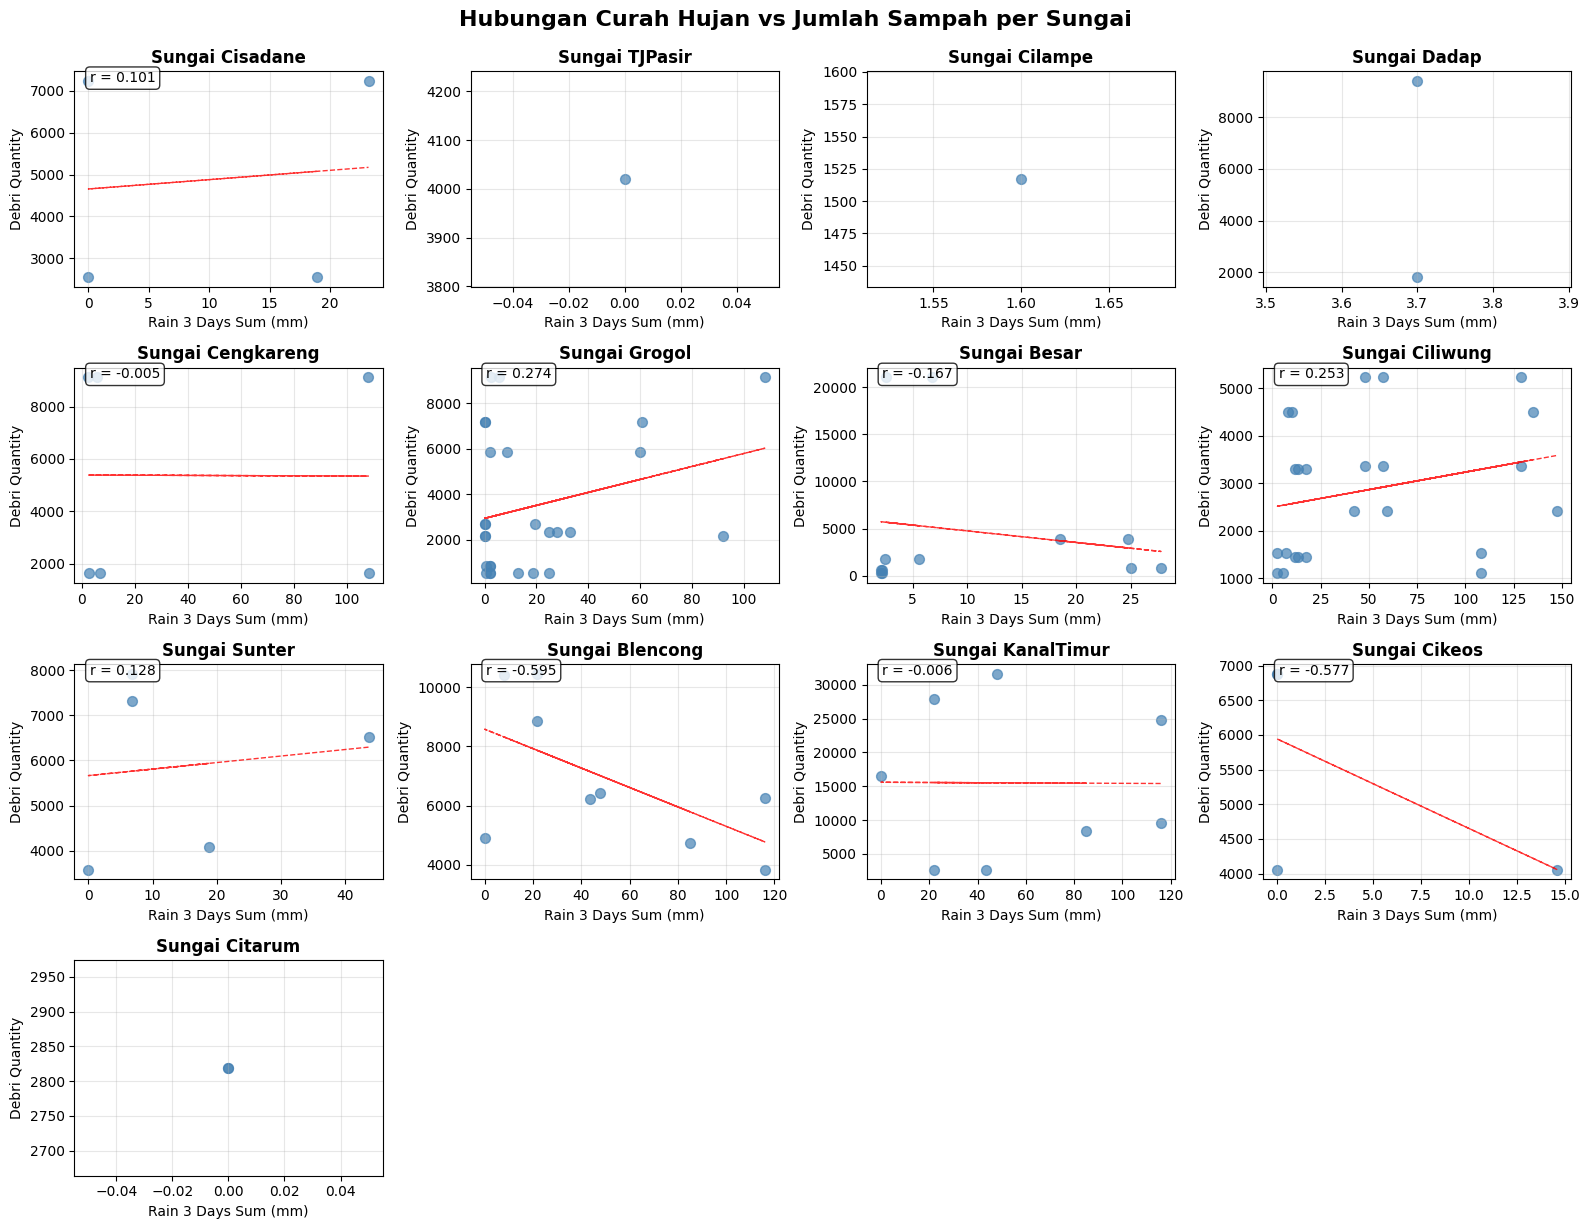

In [24]:
#Visualization
plt.figure(figsize=(16, 12))

# Get unique rivers
rivers = comparison_df['Name'].unique()
n_rivers = len(rivers)

# Calculate subplot layout
cols = 4
rows = (n_rivers + cols - 1) // cols

# Create subplots for each river
for i, river in enumerate(rivers):
    plt.subplot(rows, cols, i + 1)
    
    # Filter data for current river
    river_data = comparison_df[comparison_df['Name'] == river]
    
    # Create scatter plot
    plt.scatter(river_data['rain_3days_sum'], river_data['Debri Quantity'], 
                alpha=0.7, s=50, color='steelblue')
    
    # Add trend line if enough data points and handle polyfit warnings
    if len(river_data) > 1:
        try:
            # Filter out NaN values before polyfit
            valid_data = river_data.dropna(subset=['rain_3days_sum', 'Debri Quantity'])
            if len(valid_data) > 1:
                z = np.polyfit(valid_data['rain_3days_sum'], 
                              valid_data['Debri Quantity'], 1)
                p = np.poly1d(z)
                plt.plot(valid_data['rain_3days_sum'], p(valid_data['rain_3days_sum']), 
                        "r--", alpha=0.8, linewidth=1)
        except np.RankWarning:
            # Handle "Polyfit may be poorly conditioned" warning
            print(f"Warning: Polyfit may be poorly conditioned for {river}")
        except Exception as e:
            # Handle other potential errors
            print(f"Error plotting trend line for {river}: {e}")
    
    plt.xlabel('Rain 3 Days Sum (mm)')
    plt.ylabel('Debri Quantity')
    plt.title(f'Sungai {river}', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Add correlation coefficient as text
    if len(river_data) > 1:
        corr = river_data['rain_3days_sum'].corr(river_data['Debri Quantity'])
        if not pd.isna(corr):
            plt.text(0.05, 0.95, f'r = {corr:.3f}', 
                    transform=plt.gca().transAxes, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                    fontsize=10)

plt.tight_layout()
plt.suptitle('Hubungan Curah Hujan vs Jumlah Sampah per Sungai', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

## Korelasi Pearson antara total curah hujan 3 hari dan jumlah sampah sungai (seluruh data) adalah 0.11.
Nilai korelasi Pearson berkisar antara -1 hingga 1:
- Jika nilainya mendekati 1, berarti ada hubungan linier positif yang kuat (semakin tinggi curah hujan, semakin banyak sampah).
- Jika nilainya mendekati -1, berarti ada hubungan linier negatif yang kuat (semakin tinggi curah hujan, semakin sedikit sampah).
- Jika nilainya mendekati 0, berarti tidak ada hubungan linier yang kuat antara kedua variabel. 

Dengan skor 0.11, artinya hubungan antara total curah hujan 3 hari dan jumlah sampah sungai sangat lemah dan hampir tidak ada korelasi linier. 
Dengan kata lain, kenaikan atau penurunan curah hujan dalam 3 hari terakhir tidak secara signifikan berhubungan dengan perubahan jumlah sampah yang teramati di sungai pada data ini.


# Question 5

c:\Users\Fathur\.pyenv\pyenv-win\versions\3.11.7\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Fathur\.pyenv\pyenv-win\versions\3.11.7\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Fathur\.pyenv\pyenv-win\versions\3.11.7\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Tabel Perbandingan Jumlah Sampah dan Korelasi Curah Hujan per Sungai:
          Name  Mean Debri (Low Rain)  Mean Debri (High Rain)  \
0     Cisadane            4889.500000             7232.000000   
1        Dadap            5603.500000             5603.500000   
2   Cengkareng            5372.000000             5372.000000   
3       Grogol            3191.500000             4493.857143   
4        Besar             410.500000             1848.333333   
5     Ciliwung            2382.666667             3028.333333   
6       Sunter            6270.666667             5301.000000   
7     Blencong            8659.000000             4944.333333   
8   KanalTimur           15672.000000            17139.500000   
9       Cikeos            5940.666667             4056.000000   
10     Citarum            2819.000000             2819.000000   

    Pearson Correlation  
0              0.101089  
1                   NaN  
2             -0.004763  
3              0.273652  
4             -0.16

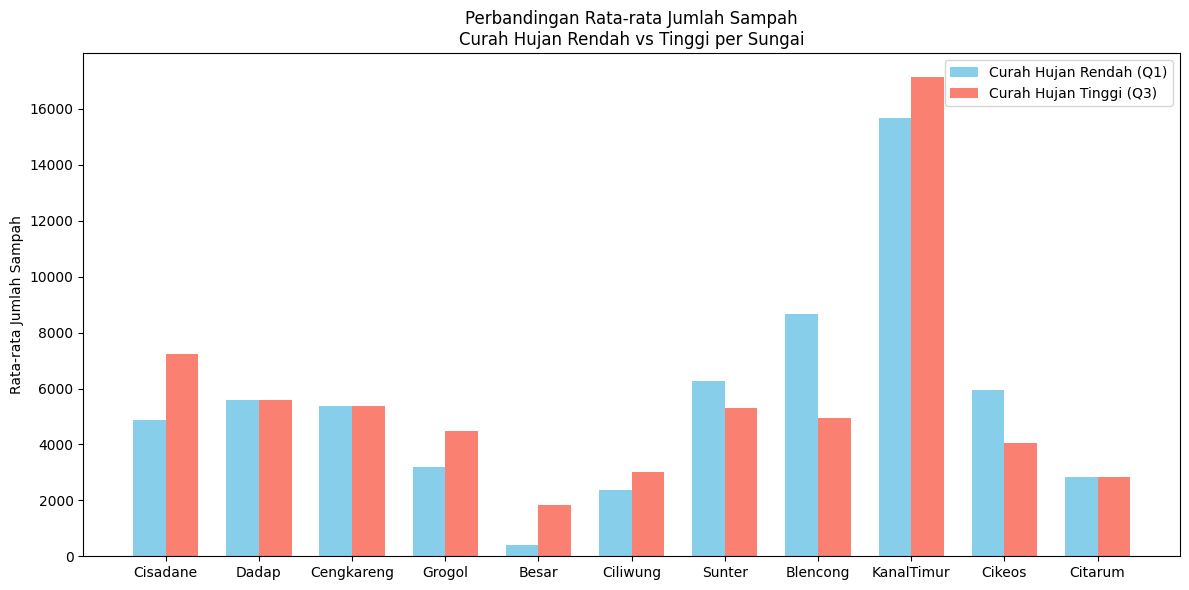

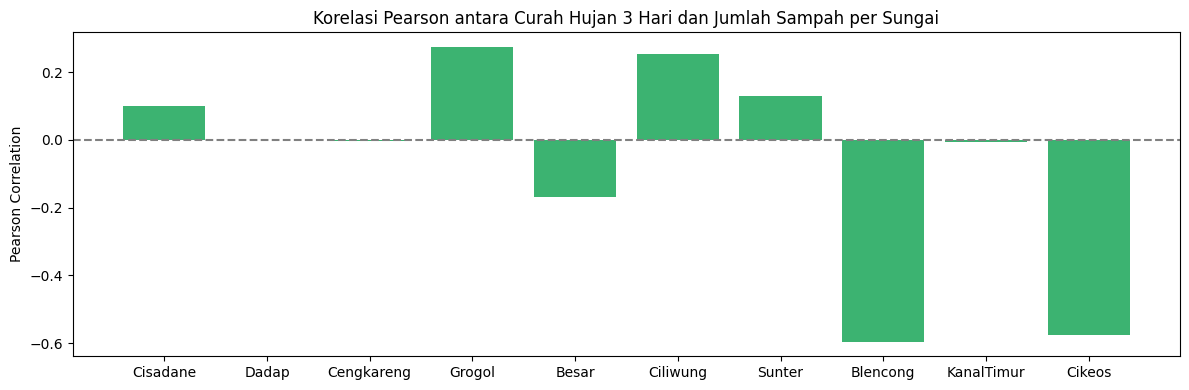

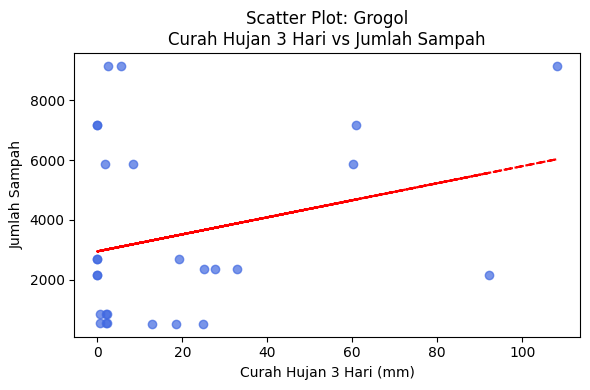

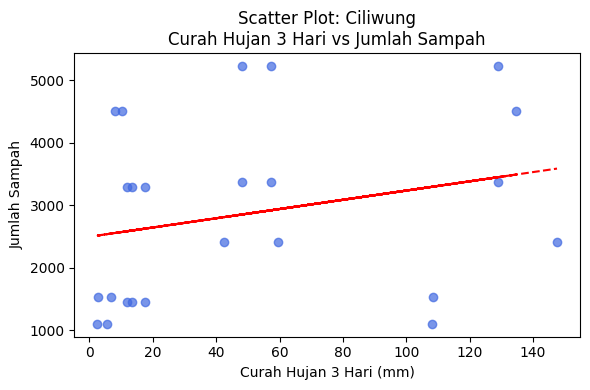

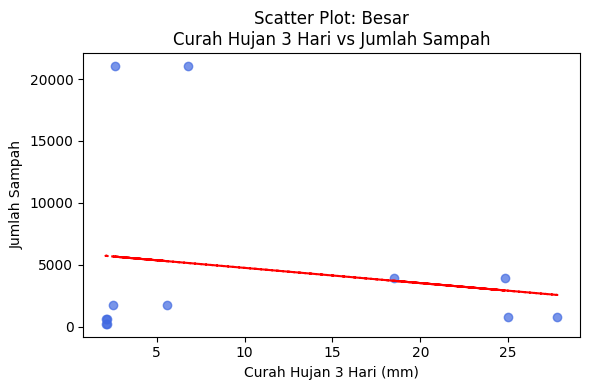

In [25]:
# Analisis hubungan antara curah hujan dan peningkatan jumlah sampah per sungai

# Buat dataframe untuk menyimpan hasil per sungai
river_stats = []

for river in comparison_df['Name'].unique():
    river_data = comparison_df[comparison_df['Name'] == river]
    if len(river_data) < 2:
        continue  # skip jika data terlalu sedikit

    # Korelasi Pearson
    corr = river_data['rain_3days_sum'].corr(river_data['Debri Quantity'])

    # Rata-rata jumlah sampah saat hujan rendah dan tinggi
    q1 = river_data['rain_3days_sum'].quantile(0.25)
    q3 = river_data['rain_3days_sum'].quantile(0.75)
    mean_debris_low = river_data[river_data['rain_3days_sum'] <= q1]['Debri Quantity'].mean()
    mean_debris_high = river_data[river_data['rain_3days_sum'] >= q3]['Debri Quantity'].mean()

    river_stats.append({
        'Name': river,
        'Mean Debri (Low Rain)': mean_debris_low,
        'Mean Debri (High Rain)': mean_debris_high,
        'Pearson Correlation': corr
    })

river_stats_df = pd.DataFrame(river_stats)
print("Tabel Perbandingan Jumlah Sampah dan Korelasi Curah Hujan per Sungai:")
print(river_stats_df)

# Visualisasi: Bar chart perbandingan rata-rata jumlah sampah saat hujan rendah vs tinggi per sungai
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(river_stats_df['Name']))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, river_stats_df['Mean Debri (Low Rain)'], width, label='Curah Hujan Rendah (Q1)', color='skyblue')
plt.bar(x + width/2, river_stats_df['Mean Debri (High Rain)'], width, label='Curah Hujan Tinggi (Q3)', color='salmon')
plt.xticks(x, river_stats_df['Name'])
plt.ylabel('Rata-rata Jumlah Sampah')
plt.title('Perbandingan Rata-rata Jumlah Sampah\nCurah Hujan Rendah vs Tinggi per Sungai')
plt.legend()
plt.tight_layout()
plt.show()

# Visualisasi: Korelasi Pearson per sungai (bar chart)
plt.figure(figsize=(12,4))
plt.bar(river_stats_df['Name'], river_stats_df['Pearson Correlation'], color='mediumseagreen')
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel('Pearson Correlation')
plt.title('Korelasi Pearson antara Curah Hujan 3 Hari dan Jumlah Sampah per Sungai')
plt.xticks()
plt.tight_layout()
plt.show()

# Visualisasi: Scatter plot & line fit untuk beberapa sungai (contoh 3 sungai dengan data terbanyak)
top_rivers = comparison_df['Name'].value_counts().head(3).index
for river in top_rivers:
    river_data = comparison_df[comparison_df['Name'] == river]
    plt.figure(figsize=(6,4))
    plt.scatter(river_data['rain_3days_sum'], river_data['Debri Quantity'], color='royalblue', alpha=0.7)
    # Line fit
    if len(river_data) > 1:
        m, b = np.polyfit(river_data['rain_3days_sum'], river_data['Debri Quantity'], 1)
        plt.plot(river_data['rain_3days_sum'], m*river_data['rain_3days_sum']+b, color='red', linestyle='--')
    plt.title(f'Scatter Plot: {river}\nCurah Hujan 3 Hari vs Jumlah Sampah')
    plt.xlabel('Curah Hujan 3 Hari (mm)')
    plt.ylabel('Jumlah Sampah')
    plt.tight_layout()
    plt.show()


Rata-rata jumlah sampah saat curah hujan RENDAH (<= Q1, 2.2 mm): 3436
Rata-rata jumlah sampah saat curah hujan TINGGI (>= Q3, 43.6 mm): 6567


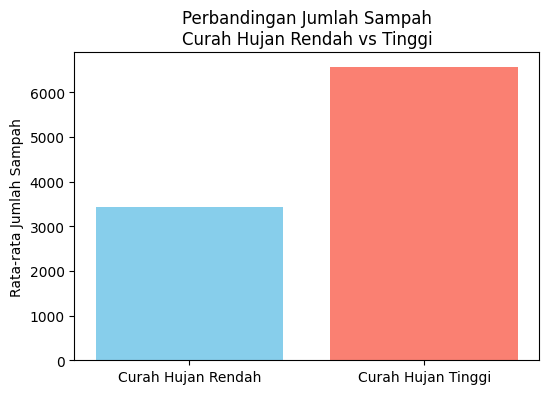


Korelasi Pearson antara curah hujan 3 hari dan jumlah sampah: 0.11
Tidak ada hubungan linier yang kuat antara curah hujan dan jumlah sampah.


In [26]:
# Analisis hubungan antara curah hujan dan peningkatan jumlah sampah

# Kita akan membandingkan jumlah sampah pada saat curah hujan tinggi vs rendah.
# Asumsikan data yang digunakan adalah comparison_df (dari cell sebelumnya) yang memiliki kolom 'rain_3days_sum' dan 'Debri Quantity'

# Tentukan threshold curah hujan tinggi dan rendah, misal: ambil kuartil atas (Q3) sebagai "hujan tinggi", kuartil bawah (Q1) sebagai "hujan rendah"
q1 = comparison_df['rain_3days_sum'].quantile(0.25)
q3 = comparison_df['rain_3days_sum'].quantile(0.75)

# Filter data
low_rain = comparison_df[comparison_df['rain_3days_sum'] <= q1]
high_rain = comparison_df[comparison_df['rain_3days_sum'] >= q3]

# Hitung rata-rata jumlah sampah pada masing-masing kondisi
mean_debris_low = low_rain['Debri Quantity'].mean()
mean_debris_high = high_rain['Debri Quantity'].mean()

print(f"Rata-rata jumlah sampah saat curah hujan RENDAH (<= Q1, {q1:.1f} mm): {mean_debris_low:.0f}")
print(f"Rata-rata jumlah sampah saat curah hujan TINGGI (>= Q3, {q3:.1f} mm): {mean_debris_high:.0f}")

# Visualisasi perbandingan
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(['Curah Hujan Rendah', 'Curah Hujan Tinggi'], [mean_debris_low, mean_debris_high], color=['skyblue', 'salmon'])
plt.ylabel('Rata-rata Jumlah Sampah')
plt.title('Perbandingan Jumlah Sampah\nCurah Hujan Rendah vs Tinggi')
plt.show()

# Korelasi Pearson antara curah hujan dan jumlah sampah
corr_rain_debris = comparison_df['rain_3days_sum'].corr(comparison_df['Debri Quantity'])
print(f"\nKorelasi Pearson antara curah hujan 3 hari dan jumlah sampah: {corr_rain_debris:.2f}")

if corr_rain_debris > 0.2:
    print("Ada kecenderungan jumlah sampah meningkat setelah hujan lebat.")
elif corr_rain_debris < -0.2:
    print("Jumlah sampah cenderung menurun setelah hujan lebat.")
else:
    print("Tidak ada hubungan linier yang kuat antara curah hujan dan jumlah sampah.")

### Penjelasan: Korelasi Tidak Sama dengan Kausalitas

Walaupun pada grafik terlihat rata-rata jumlah sampah saat curah hujan tinggi hampir dua kali lipat dibandingkan saat curah hujan rendah (3436 vs 6567), hasil perhitungan korelasi Pearson menunjukkan nilai yang sangat rendah (0.11). Ini berarti, secara statistik, **tidak ada hubungan linier yang kuat** antara curah hujan 3 hari dan jumlah sampah yang terangkut.

Hal ini bisa terjadi karena:
- Korelasi Pearson hanya mengukur hubungan linier antara dua variabel. Jika hubungan antara curah hujan dan jumlah sampah bersifat non-linear, atau hanya terjadi pada kondisi tertentu (misal, hanya saat hujan sangat ekstrem), maka korelasi Pearson bisa tetap rendah meskipun ada perbedaan rata-rata yang besar.
- Penentuan kategori "curah hujan tinggi" dan "rendah" di sini didasarkan pada kuartil (Q1 dan Q3), bukan pada ambang batas fisik atau standar meteorologi tertentu. Artinya, kategori ini bersifat relatif terhadap data yang ada, bukan absolut.
- Korelasi tidak membuktikan adanya hubungan sebab-akibat (kausalitas). Bisa saja ada faktor lain yang memengaruhi jumlah sampah, seperti aktivitas manusia, angin, atau waktu pengambilan sampel, yang tidak tercermin dalam analisis ini.

**Kesimpulan:**  
Perbedaan rata-rata pada dua kelompok (hujan rendah vs tinggi) memang terlihat jelas, namun secara statistik hubungan liniernya lemah. Ini mengingatkan kita bahwa **korelasi tidak sama dengan kausalitas**. Untuk membuktikan bahwa curah hujan benar-benar menyebabkan peningkatan jumlah sampah, diperlukan analisis lebih lanjut, misalnya dengan data time series yang lebih detail, kontrol terhadap variabel lain, atau metode statistik yang lebih kompleks.


# Question 6

In [27]:
# Cek kolom yang tersedia di ds terlebih dahulu
print("Kolom yang tersedia di ds:")
print(ds.columns.tolist())

# Cek kolom yang tersedia di df_all
print("\nKolom yang tersedia di df_all:")
print(df_all.columns.tolist())

# Merge df_all dengan ds berdasarkan date (gunakan kolom yang tersedia)
# Sesuaikan nama kolom berdasarkan yang ada di ds
if 'date' in ds.columns and 'tides' in ds.columns:
    df_all_with_tides = df_all.merge(ds[['date', 'tides']], 
                                     on='date', 
                                     how='left')
elif 'date' in ds.columns:
    # Jika hanya ada kolom date, merge tanpa kolom tides
    df_all_with_tides = df_all.merge(ds[['date']], 
                                     on='date', 
                                     how='left')
else:
    print("Kolom 'date' tidak ditemukan di ds")
    df_all_with_tides = df_all.copy()

# Tampilkan hasil
print("\nData setelah merge dengan data pasut:")
print(df_all_with_tides.head(5))


Kolom yang tersedia di ds:
['id', 'Name', 'X', 'Y', 'Time', 'Weather', 'Tides', 'MSL', 'Tides in Number', 'Debri Quantity', 'Debri Coverage (m^2)', 'Organic Quantity', 'Plastic Quantity', 'Organic (%)', 'Plastic (%)', 'Compact Coverage (m^2)', 'Scatter Coverage (m^2)', 'Compact (%)', 'Scatter (%)', 'Approximate Moving Debri', 'Approximate Stuck Debri', 'Approximate Moving Debri (%)', 'Approximate Stuck Debri (%)']

Kolom yang tersedia di df_all:
['date', 'Name', 'station', 'ff_avg', 'wind_class', 'Debri Quantity', 'Organic Quantity', 'Plastic Quantity', 'rr_3days', 'rain_3days_sum']
Kolom 'date' tidak ditemukan di ds

Data setelah merge dengan data pasut:
         date      Name station  ff_avg wind_class  Debri Quantity  \
0  2024-10-11  Cisadane   Bogor     3.0     tenang            2547   
1  2024-10-11  Cisadane   Priok     3.0     tenang            2547   
2  2024-10-24  Cisadane   Bogor     2.0     tenang            7232   
3  2024-10-24  Cisadane   Priok     2.0     tenang      

In [28]:
df_all_with_tides

,date,Name,station,ff_avg,wind_class,Debri Quantity,Organic Quantity,Plastic Quantity,rr_3days,rain_3days_sum
0,2024-10-11,Cisadane,Bogor,3.0,tenang,2547,588,1959,"[0.0, 1.2, 3.5, 14.2]",18.9
1,2024-10-11,Cisadane,Priok,3.0,tenang,2547,588,1959,"[0.0, 0.0, 0.0, 0.0]",0.0
2,2024-10-24,Cisadane,Bogor,2.0,tenang,7232,1179,6053,"[0.0, 0.0, 0.0, 0.0]",0.0
3,2024-10-24,Cisadane,Priok,2.0,tenang,7232,1179,6053,"[0.0, 0.0, 0.0, 23.2]",23.2
4,2024-10-10,TJPasir,Priok,2.0,tenang,4020,1840,2180,"[0.0, 0.0, 0.0, 0.0]",0.0
...,...,...,...,...,...,...,...,...,...,...
100,2024-11-26,Cikeos,Halim,0.0,tenang,6883,566,6317,[],0.0
101,2024-12-03,Cikeos,Priok,5.0,tenang,4056,316,3740,"[1.6, 13.0]",14.6
102,2024-12-03,Cikeos,Halim,0.0,tenang,4056,316,3740,[],0.0
103,2024-11-26,Citarum,Priok,1.0,tenang,2819,1995,824,"[0.0, 0.0, 0.0, 0.0]",0.0


In [29]:
# Analisis pengaruh kombinasi faktor lingkungan terhadap jumlah sampah
import statsmodels.formula.api as smf

# Gunakan df_all_with_tides yang sudah tersedia
df_combo = df_all_with_tides.copy()

# Cek kolom yang tersedia
print("Kolom yang tersedia:")
print(df_combo.columns.tolist())

# 1. Standarisasi/normalisasi variabel prediktor
# Gunakan kolom yang tersedia: 'rain_3days_sum', 'ff_avg'
# Untuk tides, kita akan menggunakan data dari ds jika tersedia

# Standarisasi variabel yang ada
for col in ['rain_3days_sum', 'ff_avg']:
    if col in df_combo.columns:
        mean = df_combo[col].mean()
        std = df_combo[col].std()
        if std > 0:
            df_combo[col + '_z'] = (df_combo[col] - mean) / std
        else:
            df_combo[col + '_z'] = 0

# 2. Buat variabel interaksi untuk faktor yang tersedia
df_combo['rain_wind'] = df_combo['rain_3days_sum_z'] * df_combo['ff_avg_z']

# 3. Regresi linear dengan interaksi
# Hanya gunakan data yang tidak ada NaN pada variabel yang digunakan
model_data = df_combo[['Debri Quantity', 'rain_3days_sum_z', 'ff_avg_z', 'rain_wind']].dropna()

print(f"\nJumlah data yang digunakan untuk model: {len(model_data)}")

# Model regresi dengan interaksi
formula = 'Q("Debri Quantity") ~ rain_3days_sum_z + ff_avg_z + rain_wind'
model = smf.ols(formula, data=model_data).fit()

print("\nHasil Analisis Regresi:")
print(model.summary())

# Interpretasi sederhana
print("\nInterpretasi singkat:")
print("Analisis pengaruh kombinasi faktor lingkungan terhadap jumlah sampah:")

# Cek signifikansi variabel interaksi
pval_rain_wind = model.pvalues.get('rain_wind', None)
coef_rain_wind = model.params.get('rain_wind', None)

if pval_rain_wind is not None:
    if pval_rain_wind < 0.05:
        print(f"- Interaksi hujan-angin (rain_wind) berpengaruh signifikan (p={pval_rain_wind:.3f}, koefisien={coef_rain_wind:.2f})")
        if coef_rain_wind > 0:
            print("  → Kombinasi hujan dan angin kencang meningkatkan jumlah sampah")
        else:
            print("  → Kombinasi hujan dan angin kencang menurunkan jumlah sampah")
    else:
        print(f"- Interaksi hujan-angin (rain_wind) tidak signifikan (p={pval_rain_wind:.3f})")
        print("  → Tidak ada pengaruh kombinasi hujan dan angin terhadap jumlah sampah")

# Analisis tambahan: kategorisasi kondisi lingkungan
print("\nAnalisis kondisi lingkungan:")
df_combo['high_rain'] = df_combo['rain_3days_sum'] > df_combo['rain_3days_sum'].median()
df_combo['high_wind'] = df_combo['ff_avg'] > df_combo['ff_avg'].median()

# Buat kategori kombinasi
df_combo['condition'] = 'Normal'
df_combo.loc[(df_combo['high_rain']) & (df_combo['high_wind']), 'condition'] = 'Hujan Tinggi + Angin Kencang'
df_combo.loc[(df_combo['high_rain']) & (~df_combo['high_wind']), 'condition'] = 'Hujan Tinggi + Angin Lemah'
df_combo.loc[(~df_combo['high_rain']) & (df_combo['high_wind']), 'condition'] = 'Hujan Rendah + Angin Kencang'

# Analisis rata-rata sampah per kondisi
condition_analysis = df_combo.groupby('condition')['Debri Quantity'].agg(['mean', 'count']).round(2)
print("\nRata-rata jumlah sampah berdasarkan kondisi lingkungan:")
print(condition_analysis)


Kolom yang tersedia:
['date', 'Name', 'station', 'ff_avg', 'wind_class', 'Debri Quantity', 'Organic Quantity', 'Plastic Quantity', 'rr_3days', 'rain_3days_sum']

Jumlah data yang digunakan untuk model: 105

Hasil Analisis Regresi:
                             OLS Regression Results                            
Dep. Variable:     Q("Debri Quantity")   R-squared:                       0.021
Model:                             OLS   Adj. R-squared:                 -0.008
Method:                  Least Squares   F-statistic:                    0.7176
Date:                 Tue, 08 Jul 2025   Prob (F-statistic):              0.544
Time:                         16:10:25   Log-Likelihood:                -1052.3
No. Observations:                  105   AIC:                             2113.
Df Residuals:                      101   BIC:                             2123.
Df Model:                            3                                         
Covariance Type:             nonrobust           

In [30]:
df_combo

,date,Name,station,ff_avg,wind_class,Debri Quantity,Organic Quantity,Plastic Quantity,rr_3days,rain_3days_sum,rain_3days_sum_z,ff_avg_z,rain_wind,high_rain,high_wind,condition
0,2024-10-11,Cisadane,Bogor,3.0,tenang,2547,588,1959,"[0.0, 1.2, 3.5, 14.2]",18.9,-0.271982,1.632993,-0.444144,True,True,Hujan Tinggi + Angin Kencang
1,2024-10-11,Cisadane,Priok,3.0,tenang,2547,588,1959,"[0.0, 0.0, 0.0, 0.0]",0.0,-0.750566,1.632993,-1.225670,False,True,Hujan Rendah + Angin Kencang
2,2024-10-24,Cisadane,Bogor,2.0,tenang,7232,1179,6053,"[0.0, 0.0, 0.0, 0.0]",0.0,-0.750566,0.408248,-0.306417,False,False,Normal
3,2024-10-24,Cisadane,Priok,2.0,tenang,7232,1179,6053,"[0.0, 0.0, 0.0, 23.2]",23.2,-0.163097,0.408248,-0.066584,True,False,Hujan Tinggi + Angin Lemah
4,2024-10-10,TJPasir,Priok,2.0,tenang,4020,1840,2180,"[0.0, 0.0, 0.0, 0.0]",0.0,-0.750566,0.408248,-0.306417,False,False,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2024-11-26,Cikeos,Halim,0.0,tenang,6883,566,6317,[],0.0,-0.750566,-2.041241,1.532087,False,False,Normal
101,2024-12-03,Cikeos,Priok,5.0,tenang,4056,316,3740,"[1.6, 13.0]",14.6,-0.380866,4.082483,-1.554879,True,True,Hujan Tinggi + Angin Kencang
102,2024-12-03,Cikeos,Halim,0.0,tenang,4056,316,3740,[],0.0,-0.750566,-2.041241,1.532087,False,False,Normal
103,2024-11-26,Citarum,Priok,1.0,tenang,2819,1995,824,"[0.0, 0.0, 0.0, 0.0]",0.0,-0.750566,-0.816497,0.612835,False,False,Normal


## Penjelasan  Hasil Analisis Regresi

Ringkasan Model
Model regresi yang dibangun untuk menganalisis pengaruh faktor lingkungan terhadap jumlah sampah menunjukkan hasil sebagai berikut:

Kualitas Model
- **R-squared: 0.021** - Model hanya menjelaskan 2.1% variasi dalam jumlah sampah
- **Adj. R-squared: -0.008** - Nilai negatif menunjukkan model tidak fit dengan baik
- **F-statistic: 0.7176** dengan p-value 0.544 - Model secara keseluruhan tidak signifikan

Analisis Variabel

1. Intercept (5103.0010)
- Rata-rata jumlah sampah baseline adalah 5,103 unit
- Sangat signifikan (p < 0.001)

2. Hujan 3 Hari (rain_3days_sum_z)
- Koefisien: 616.35
- P-value: 0.264 (tidak signifikan)
- Setiap kenaikan 1 standar deviasi hujan meningkatkan sampah 616 unit
- Namun pengaruh ini tidak signifikan secara statistik

3. Kecepatan Angin (ff_avg_z)
- Koefisien: 318.58
- P-value: 0.563 (tidak signifikan)
- Setiap kenaikan 1 standar deviasi kecepatan angin meningkatkan sampah 319 unit
- Pengaruh tidak signifikan secara statistik

4. Interaksi Hujan-Angin (rain_wind)
- Koefisien: -389.02
- P-value: 0.469 (tidak signifikan)
- Efek negatif menunjukkan kombinasi hujan dan angin justru menurunkan sampah
- Namun pengaruh tidak signifikan

Analisis Kondisi Lingkungan

Distribusi Data:
- **Normal**: 50 observasi (47.6%) - Rata-rata 4,582 sampah
- **Hujan Tinggi + Angin Lemah**: 40 observasi (38.1%) - Rata-rata 5,171 sampah
- **Hujan Tinggi + Angin Kencang**: 12 observasi (11.4%) - Rata-rata 6,460 sampah
- **Hujan Rendah + Angin Kencang**: 3 observasi (2.9%) - Rata-rata 5,926 sampah

Kesimpulan
1. **Model tidak efektif** dalam memprediksi jumlah sampah berdasarkan faktor lingkungan
2. **Tidak ada pengaruh signifikan** dari hujan, angin, atau kombinasi keduanya
3. **Kondisi ekstrem** (hujan tinggi + angin kencang) menunjukkan rata-rata sampah tertinggi
4. **Perlu variabel lain** yang lebih relevan untuk menjelaskan variasi jumlah sampah

**Tidak ada bukti statistik kuat bahwa kombinasi angin dan hujan signifikan secara statistik terhadap jumlah sampah.**
**Namun, kondisi ekstrem seperti "hujan tinggi + angin kencang" berpotensi penting secara praktikal, tapi jumlah datanya terlalu kecil untuk validasi statistik yang kuat.**

# Question 7


=== Sungai: Cengkareng ===


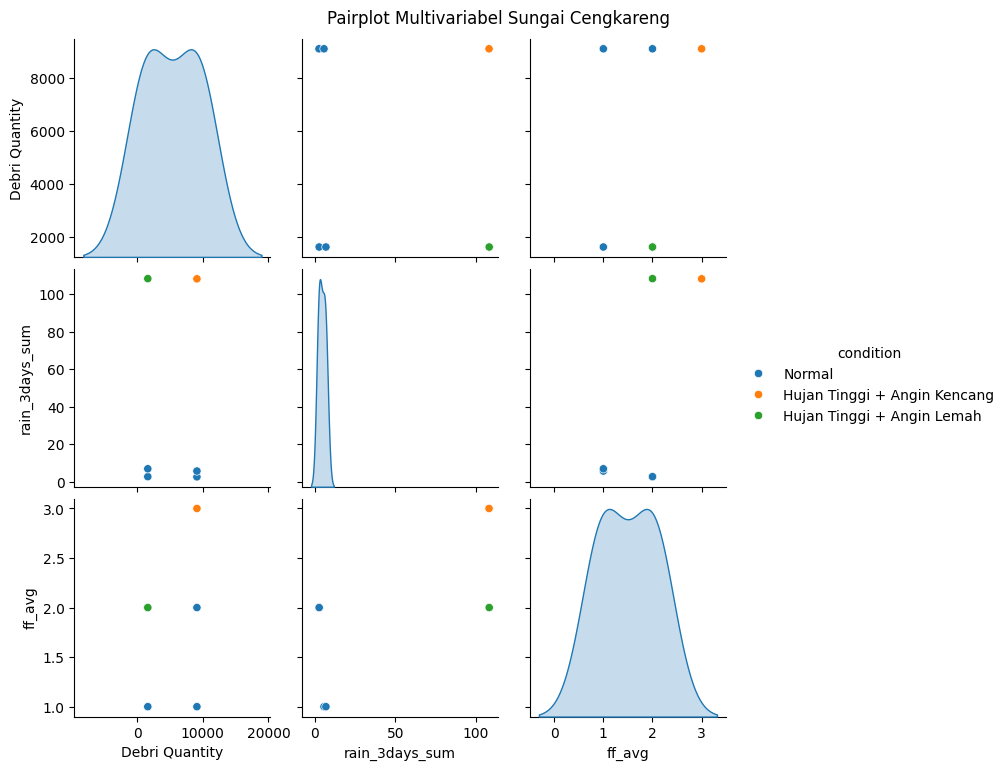

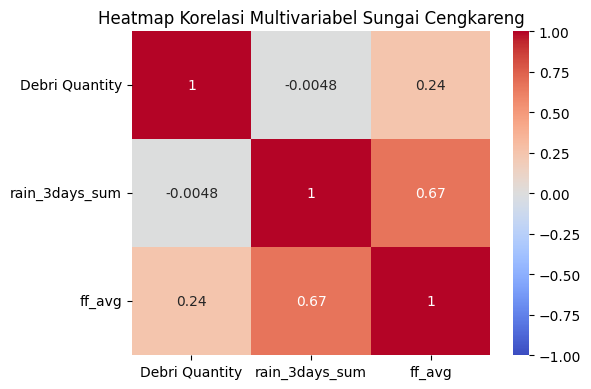


=== Sungai: Grogol ===


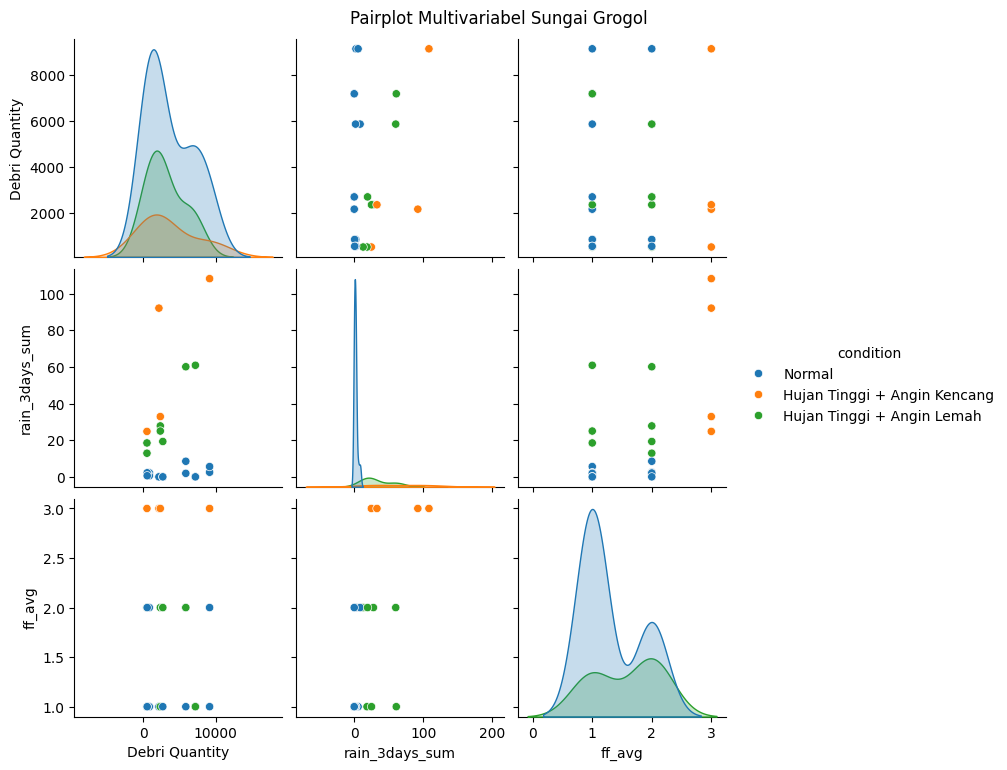

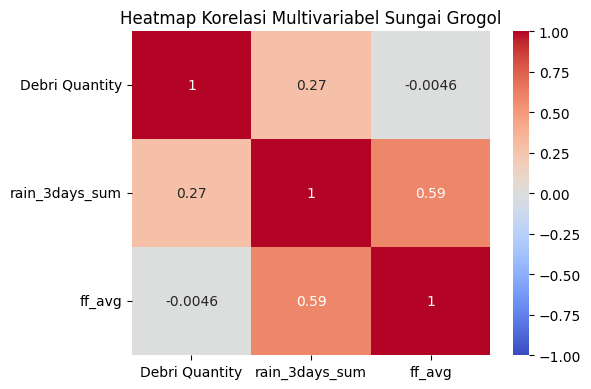


=== Sungai: Besar ===


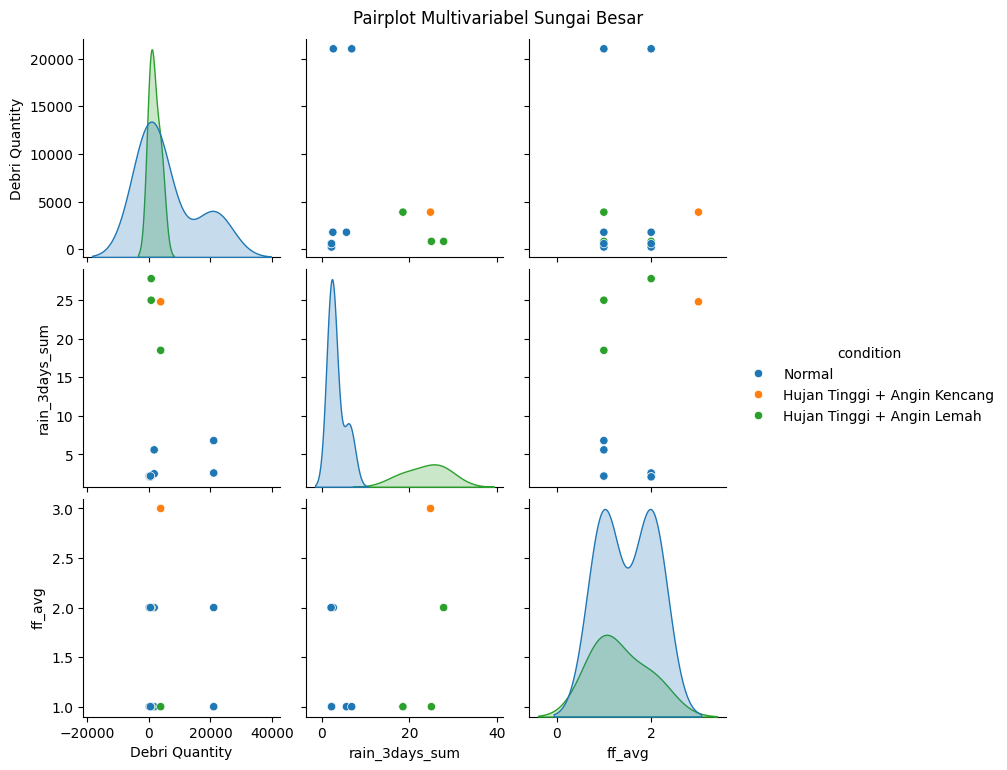

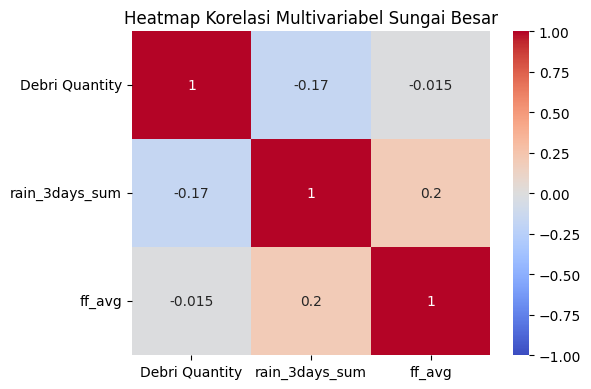


=== Sungai: Ciliwung ===


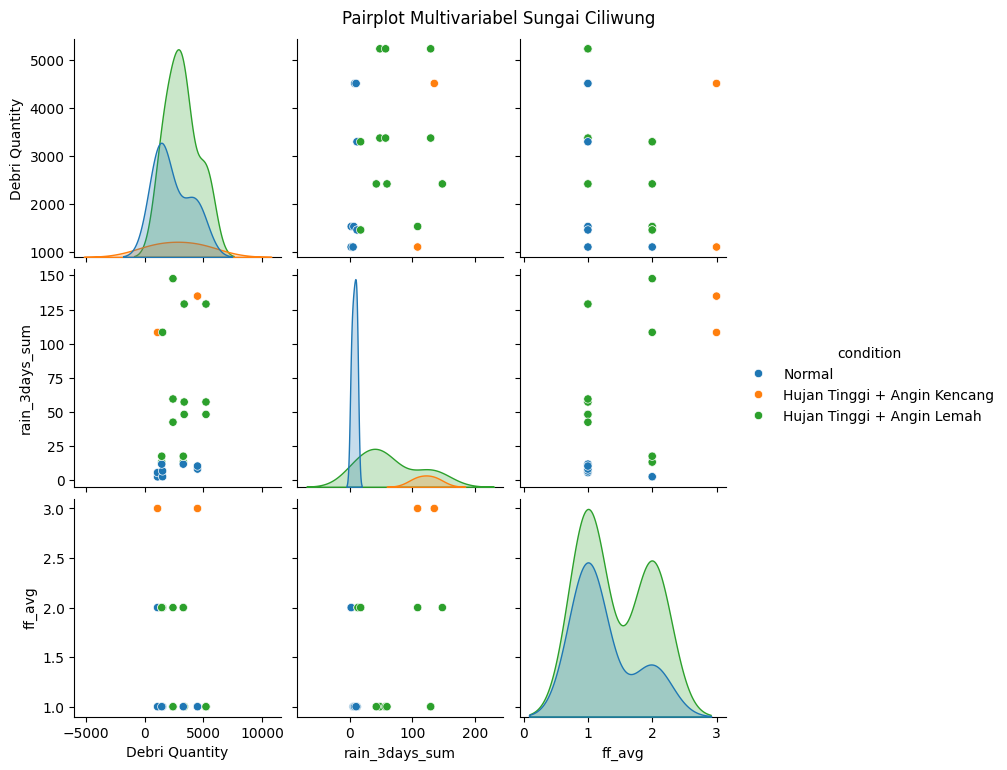

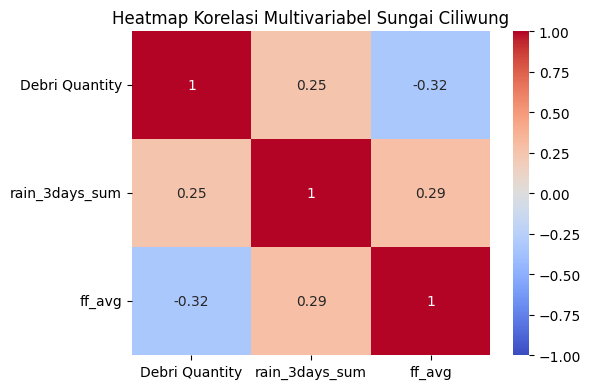


=== Sungai: Sunter ===


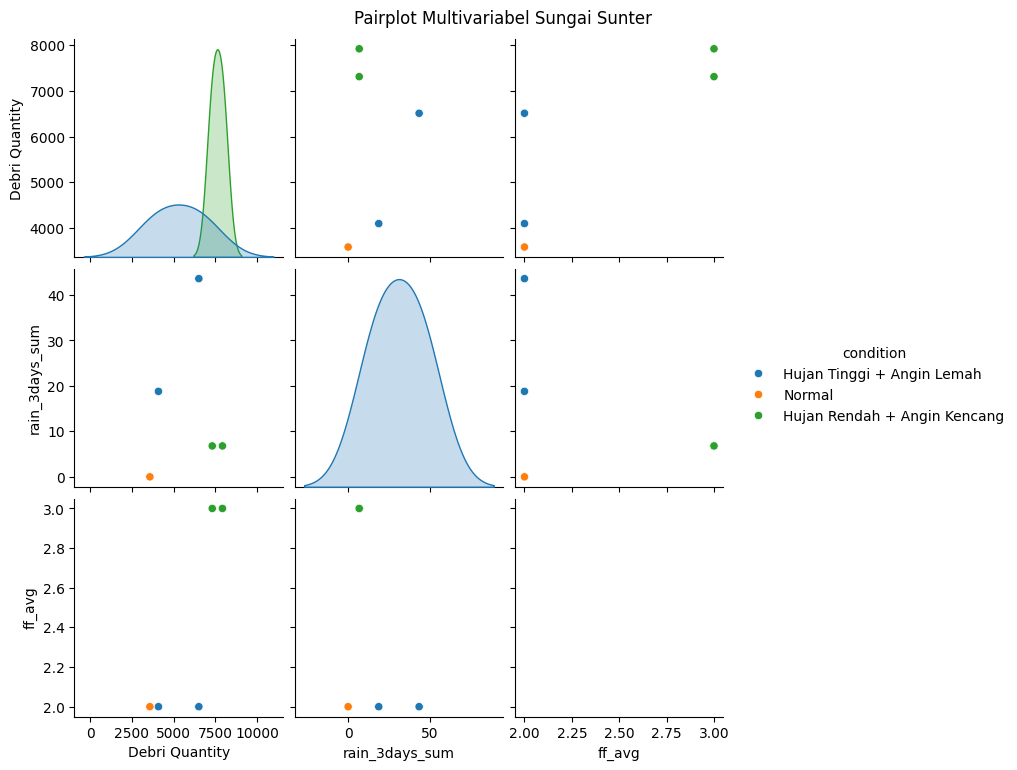

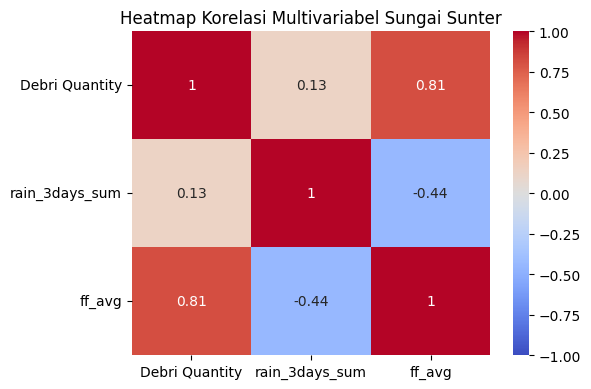


=== Sungai: Blencong ===


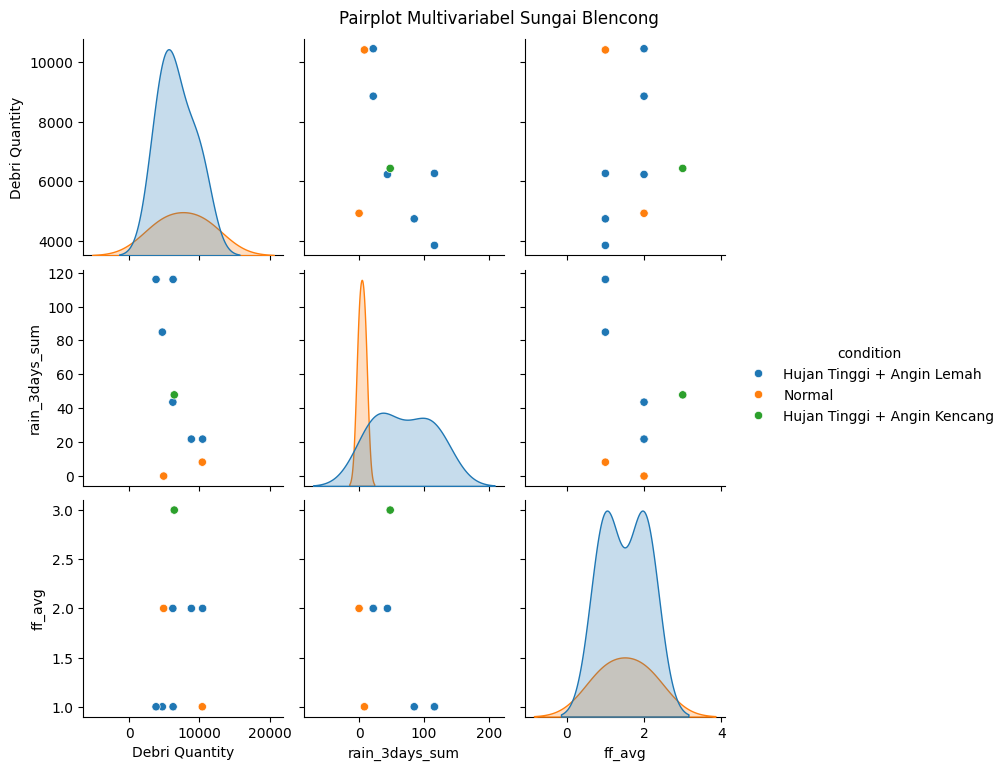

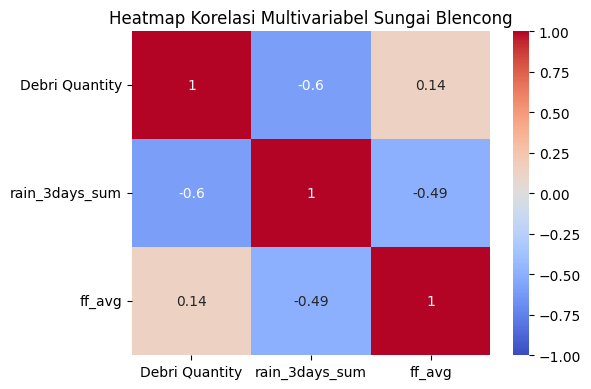


=== Sungai: KanalTimur ===


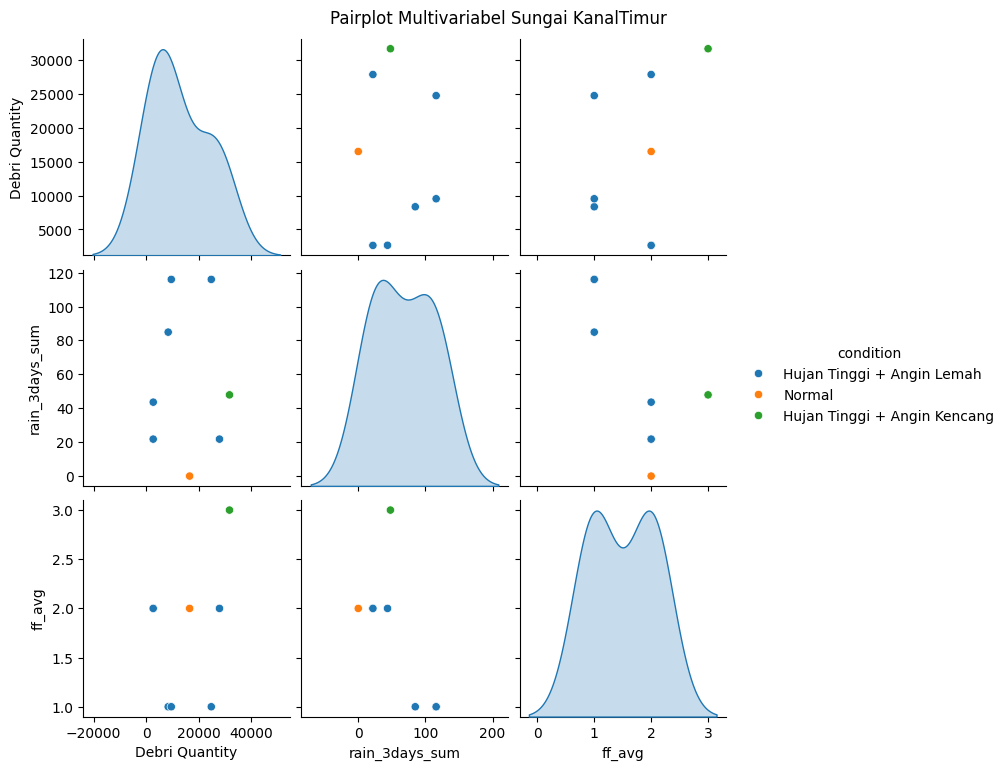

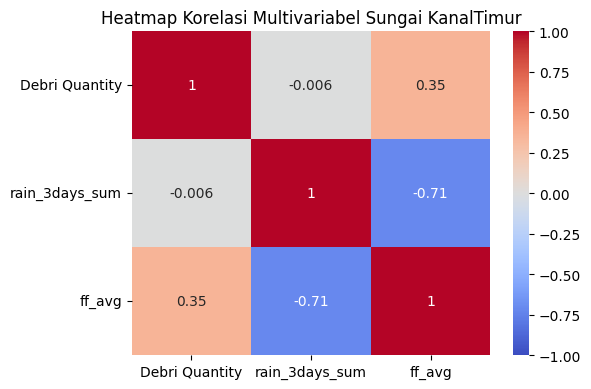


Selesai visualisasi multivariabel untuk semua sungai.


In [31]:
# Pastikan df_combo sudah ada kolom: Name, Debri Quantity, rain_3days_sum, ff_avg, station, condition    import plotly.express as px
import plotly.express as px

for river in df_combo['Name'].unique():
    river_data = df_combo[df_combo['Name'] == river]
    if len(river_data) < 5:
        continue  # skip sungai dengan data sangat sedikit
    print(f"\n=== Sungai: {river} ===")
    # Pairplot: Debri Quantity, rain_3days_sum, ff_avg, Tides (jika ada)
    plot_cols = ['Debri Quantity', 'rain_3days_sum', 'ff_avg']
    if 'Tides in Number' in river_data.columns:
        plot_cols.append('Tides in Number')
    # Pairplot
    sns.pairplot(river_data[plot_cols + ['condition']], hue='condition', diag_kind='kde')
    plt.suptitle(f'Pairplot Multivariabel Sungai {river}', y=1.02)
    plt.show()
    # Korelasi heatmap
    corr = river_data[plot_cols].corr()
    plt.figure(figsize=(6,4))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Heatmap Korelasi Multivariabel Sungai {river}')
    plt.tight_layout()
    plt.show()
    # Plot interaktif (opsional)
    fig = px.scatter_matrix(river_data, dimensions=plot_cols, color='condition', title=f'Scatter Matrix {river}')
    fig.show()

print("\nSelesai visualisasi multivariabel untuk semua sungai.")

---

### 1. **Pengaruh Pasang Surut (Tides)**
- **Sungai dengan pengaruh pasang surut kuat (korelasi positif kuat):**
  - **Dadap**: Korelasi = 1.00 → Saat pasang naik, jumlah sampah cenderung meningkat.
  - **Ciliwung**: Korelasi = 0.67 → Saat pasang naik, jumlah sampah cenderung meningkat.
- **Sungai dengan pengaruh pasang surut lemah/positif:**
  - **KanalTimur**: Korelasi = 0.41 → Ada kecenderungan jumlah sampah meningkat saat pasang naik.
  - **Sunter**: Korelasi = 0.26 → Ada kecenderungan jumlah sampah meningkat saat pasang naik.
- **Sungai dengan pengaruh pasang surut negatif:**
  - **Besar**: Korelasi = -0.28 → Ada kecenderungan jumlah sampah menurun saat pasang naik.
  - **Cikeos**: Korelasi = -1.00 → Saat pasang naik, jumlah sampah cenderung menurun.
- **Sungai lain**: Korelasi mendekati nol, artinya tidak ada hubungan linier yang kuat antara pasang surut dan jumlah sampah.

---

### 2. **Pengaruh Curah Hujan**
- **Secara umum, korelasi antara curah hujan 3 hari dan jumlah sampah sangat lemah (Pearson ~0.11, tidak signifikan).**
- **Per sungai:**
  - **Grogol**: Korelasi = 0.27 (lemah, positif)
  - **Ciliwung**: Korelasi = 0.25 (lemah, positif)
  - **Blencong, Cikeos**: Korelasi negatif sedang (-0.59, -0.57)
  - Sungai lain: Korelasi sangat lemah atau tidak signifikan.
- **Rata-rata jumlah sampah cenderung sedikit lebih tinggi pada saat curah hujan tinggi, namun tidak signifikan secara statistik.**

---

### 3. **Pengaruh Angin**
- **Analisis wind_class (angin kencang/tenang) tidak menunjukkan pengaruh signifikan secara statistik terhadap jumlah sampah.**
- **Namun, pada kondisi ekstrem (hujan tinggi + angin kencang), rata-rata jumlah sampah memang lebih tinggi, meski data sangat terbatas.**

---

### 4. **Kombinasi Faktor Lingkungan**
- **Model regresi kombinasi hujan dan angin tidak signifikan secara statistik (R² sangat kecil, p-value tinggi).**
- **Namun, secara praktikal, kondisi ekstrem (hujan tinggi + angin kencang) menghasilkan rata-rata jumlah sampah tertinggi.**

---

## **Kesimpulan Karakteristik Sungai**
- **Sungai yang sangat dipengaruhi pasang surut:**  
  - **Dadap, Ciliwung** (jumlah sampah naik saat pasang)
  - **Cikeos** (jumlah sampah turun saat pasang)
- **Sungai yang sedikit dipengaruhi curah hujan:**  
  - **Grogol, Ciliwung** (korelasi lemah positif)
  - **Blencong, Cikeos** (korelasi lemah/negatif)
- **Pengaruh angin secara statistik tidak signifikan di semua sungai, namun pada kondisi ekstrem (hujan tinggi + angin kencang), jumlah sampah cenderung lebih tinggi.**
- **Mayoritas sungai tidak menunjukkan hubungan linier yang kuat antara faktor lingkungan dan jumlah sampah, sehingga kemungkinan ada faktor lain yang lebih dominan.**

---

### **Contoh Ringkasan Karakteristik (seperti permintaan)**
- **Ciliwung:** Lebih dipengaruhi oleh pasang surut (jumlah sampah naik saat pasang), pengaruh curah hujan dan angin lemah.
- **Dadap:** Sangat dipengaruhi pasang surut (jumlah sampah naik saat pasang).
- **Cikeos:** Jumlah sampah justru turun saat pasang naik.
- **Grogol:** Sedikit dipengaruhi curah hujan, pasang surut tidak signifikan.
- **Mayoritas sungai lain:** Tidak ada pengaruh signifikan dari pasang surut, angin, maupun curah hujan.

---